# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка библиотек и загрузка данных

In [443]:
!pip install scikit-learn==1.1.3

In [444]:
!pip install ydata_profiling

In [445]:
!pip install sweetviz

In [446]:
!pip install phik

In [447]:
import pandas as pd
from ydata_profiling import ProfileReport
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor

In [448]:
auto = pd.read_csv('/datasets/autos.csv')

### Обзор данных

#### Краткий обзор данных

In [449]:
auto.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

In [450]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [451]:
auto.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [452]:
auto.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [453]:
display(auto.groupby('Model')['Price'].agg('count').reset_index())

Model  Price
0        100    417
1        145     49
2        147    572
3        156    629
4        159    212
..       ...    ...
245    yaris   1033
246     yeti    174
247  ypsilon    209
248  z_reihe    717
249   zafira   3044

[250 rows x 2 columns]

**Вывод:**
* Загружен свод данных с количеством строк, равным 354369;
* Необходимо привести наименования признаков к общепризнанному типу написания;
* Необходимо привести признаки DateCrawled, DateCreated, LastSeen к типу data (Признак Repaired можно было бы привести к типу bool, но в данном столбце содержатся пустые значения, которые невозможно заполнить на основе прочих данных);
* В данных присутствуют пропуски в показателях: VehicleType (37490), Gearbox (19833), Model (19705), FuelType (32895), Repaired (71154);
* На основе признаков DateCrawled, DateCreated нужно создать новый столбец - количество дней публикации анкеты. После создания новых столбцов показатели DateCrawled и DateCreated будут не нужны;
* Необходимо удалить столбец RegistrationMonth, т.к. месяц регистрации автомобиля не должен оказывать сильное влияние на его стоимость (в отличие от RegistrationYear);
* Необходимо удалить столбец PostalCode - по индексу можно определить местонахождение автомобиля, в зависимости от которого стоимость действительно может измениться. Но в моделях регрессии с увеличением почтового индекса будет увеличиваться/уменьшаться целевой показатель, в то время как увеличение стоимости автомобилей может происходить только для узких диапазонов индексов;
* Необходимо удалить столбец LastSeen - показатель последней активности пользователя не должен оказывать влияния на стоимость автомобиля;
* Необходимо удалить столбец NumberOfPictures, так как он заполнен нулями;
* В выгрузке 250 различных моделей различных производителей. При построении модели наименования моделей нам не понадобятся, так как различные модели одного бренда различаются техническими характеристиками - мощностью, типом коробки передач, типом транспортного средства, и т.д. Получается, что признак модели уже закодирован в остальных признаках, и поэтому признак Model нужно удалить;
* Вместо показателя RegistrationYear нужно рассчитать возраст автомобиля и затем провести его нормализацию;
* Необходимо провести нормализацию для показателей Power, Kilometer;
* Необходимо применить OHE и OE к показателям VehicleType, Gearbox, Model, FuelType, Brand, Repaired;
* Также нужно дополнительно исследовать данные на предмет дубликатов и аномалий.

#### Изменение форматов данных, переименование столбцов и добавление новых

Так как с некорректными типами данных неудобно проводить анализ, осуществим их предобработку заранее. Также для дальнейшего удобства изменим написание наименований столбцов. В целях проведения анализа сразу создадим необходимые дополнительные столбцы

In [454]:
#Переименование столбцов
auto.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

In [455]:
#Изменение типов данных для столбцов с датами
auto['date_crawled'] = pd.to_datetime(auto['date_crawled'], format='%Y-%m-%d %H:%M:%S')
auto['date_created'] = pd.to_datetime(auto['date_created'], format='%Y-%m-%d %H:%M:%S')
auto['last_seen'] = pd.to_datetime(auto['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [456]:
#Добавление новых столбцов
#Количество дней между датой создания анкеты и датой выгрузки
auto['publication_days'] = ((auto['date_crawled']-auto['date_created'])/ np.timedelta64 ( 1 , 'D')).round(0).astype('int')
#Bозраст автомобиля
#Год регистрации - не лучший признак для определения возраста автомобиля, но все равно наиболее приближенный
auto['age'] = pd.DatetimeIndex(auto['date_crawled']).year - auto['registration_year']

In [457]:
auto[['publication_days', 'age']].describe()

publication_days            age
count     354369.000000  354369.000000
mean           0.846716      11.765552
std            2.166379      90.227958
min            0.000000   -7983.000000
25%            1.000000       8.000000
50%            1.000000      13.000000
75%            1.000000      17.000000
max          737.000000    1016.000000

#### Анализ показателей

##### Анализ данных средствами ydata_profiling

In [458]:
ProfileReport(auto)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Анализ данных средствами sweetviz

In [459]:
report = sv.analyze(auto)
report.show_html('common analysis.html')

                                             |          | [  0%]   00:00 -> (? left)

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##### Анализ качественных показателей

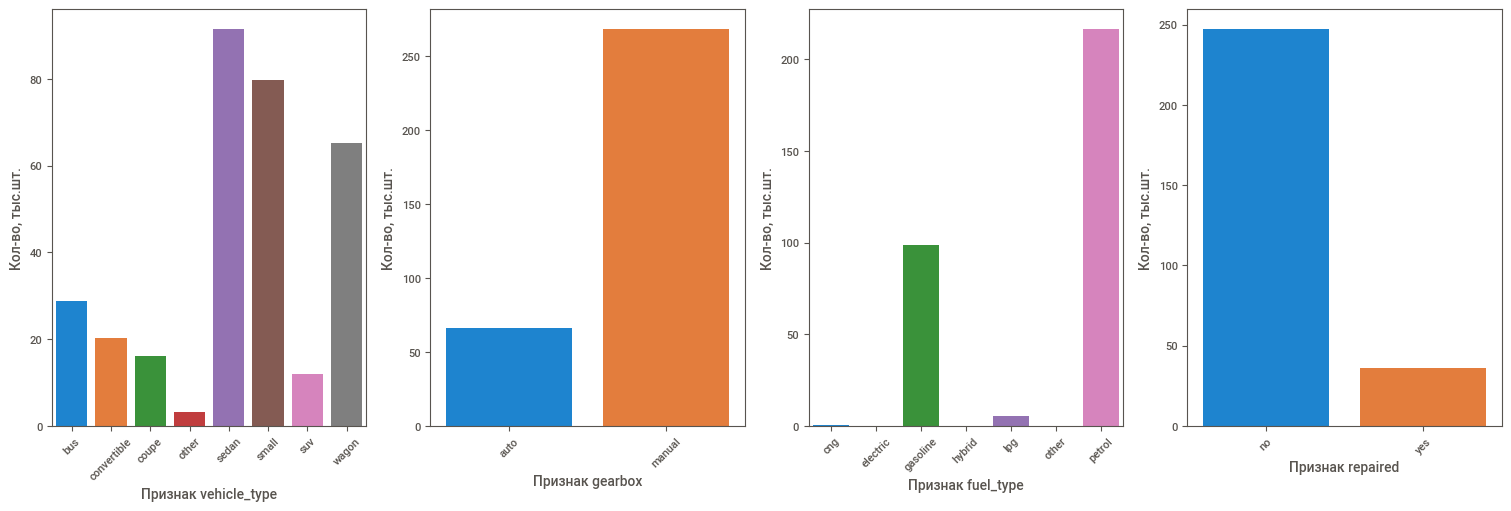

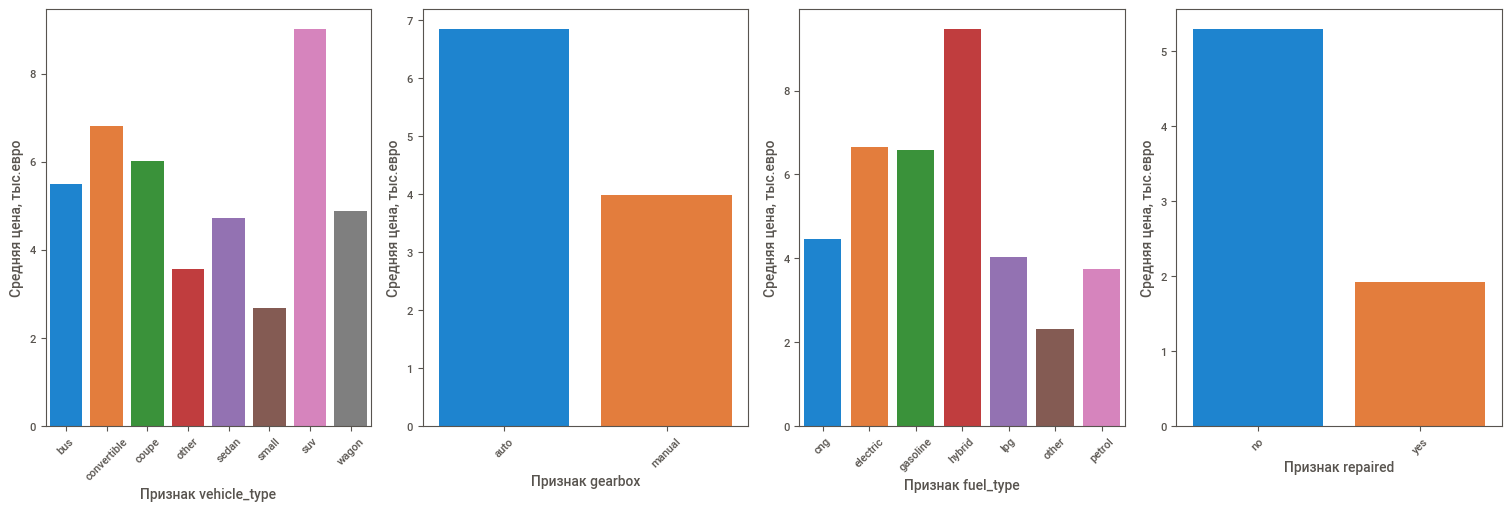

In [460]:
#Столбиковая диаграмма по качественным показателям
for i in ['count', 'mean']:
    fig, axs = plt.subplots(1, 4, figsize=(15, 5), constrained_layout=True)
    diag_col = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
    
    for index, column in enumerate(diag_col):
        data_column = auto.groupby(column)['price'].agg(i).reset_index().sort_values(by=column)
        data_column['price'] = data_column['price']/1000
        diagram = sns.barplot(data=data_column, y='price', x=column, ax=axs[index])
        diagram.set_xlabel('Признак '+column)
        axs[index].set_xticklabels(axs[index].get_xticklabels(), rotation=45)
        
        if i=='count':
            axs[index].set_ylabel('Кол-во, тыс.шт.')
        else:
            axs[index].set_ylabel('Средняя цена, тыс.евро')

**Вывод:**

* В выгрузке содержатся данные по автомобилям 8 разных типов. Чаще всего встречаются автомобили типов sedan, small и wagon. При этом эти типы автомобилей не обладают высокой средней стоимостью - обычно до 5 000 евро;
* Автомобилей с ручной коробкой передач в выгрузке более чем в 4 раза больше, чем автомобилей на автоматической коробке. При этом автомобили с автоматической коробкой более чем в 1,5 раза дороже, чем автомобили на ручной;
* В основном в выгрузке представлены автомобили, работающие на бензине. Gasoline и petrol - это одно и то же, поэтому на эиапе корректировки данных нужно поправить название. Автомобилей, использующих другой тип топлива, совсем немного, поэтому модель может плохо предсказывать их стоимость;
* Автомобилей, которые не ремонтировались, в выборке примерно в 5 раз больше, чем тех, которые побывали в ремонте. В среднем стоимость отремонтированного автомобиля в 2,5 раза меньше, чем неотремонтированного

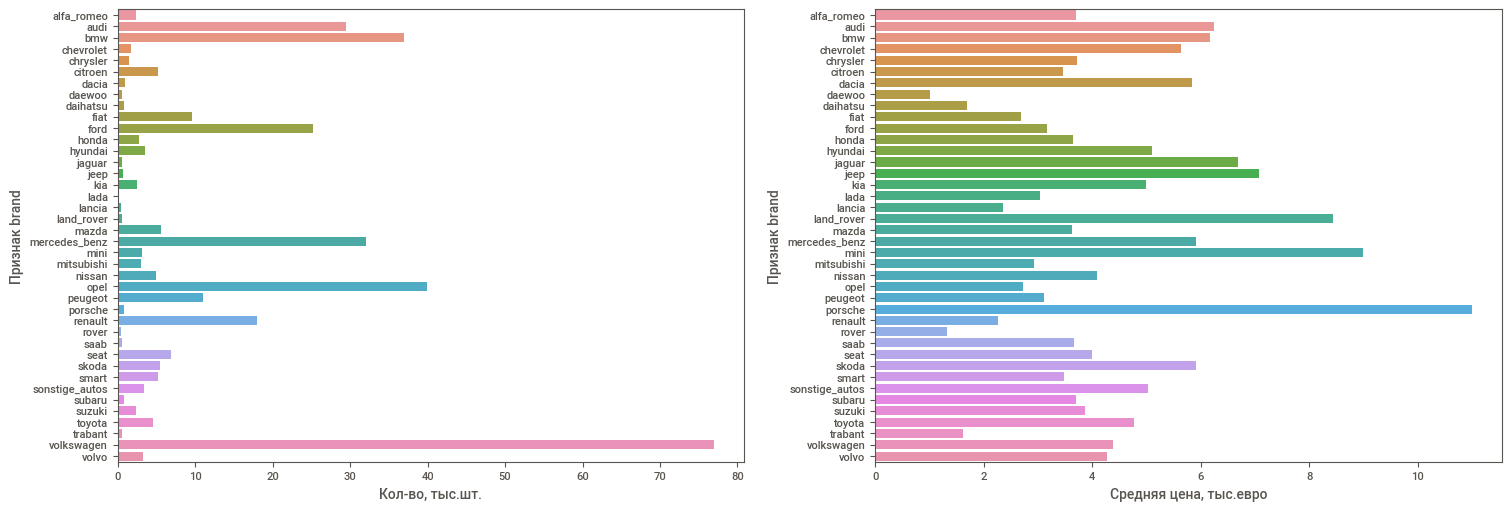

In [461]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
i = ['count', 'mean']

for index, func in enumerate(i):
    data_column = auto.groupby('brand')['price'].agg(func).reset_index().sort_values(by='brand')
    data_column['price'] = data_column['price']/1000
    diagram = sns.barplot(data=data_column, y='brand', x='price', ax=axs[index], orient = 'h')
    axs[index].set_ylabel('Признак brand')
    
    if func=='count':
        diagram.set_xlabel('Кол-во, тыс.шт.')
    else:
        diagram.set_xlabel('Средняя цена, тыс.евро')

**Вывод:**

* В выгрузке больше всего автомобилей Volkswagen, Opel, BMW, Mercedes-Benz, Audi, Ford, Renault;
* Автомобили с самой низкой стоимостью: Daewoo, Rover, Trabant. При этом заводы Rover и Trabant уже проданы/закрыты, поэтому в продаже есть только старые модели;
* Автомобили с самой высокой стоимостью: Porsche, Mini, Land Rover, Jeep, Jaguar.

##### Анализ количественных показателей

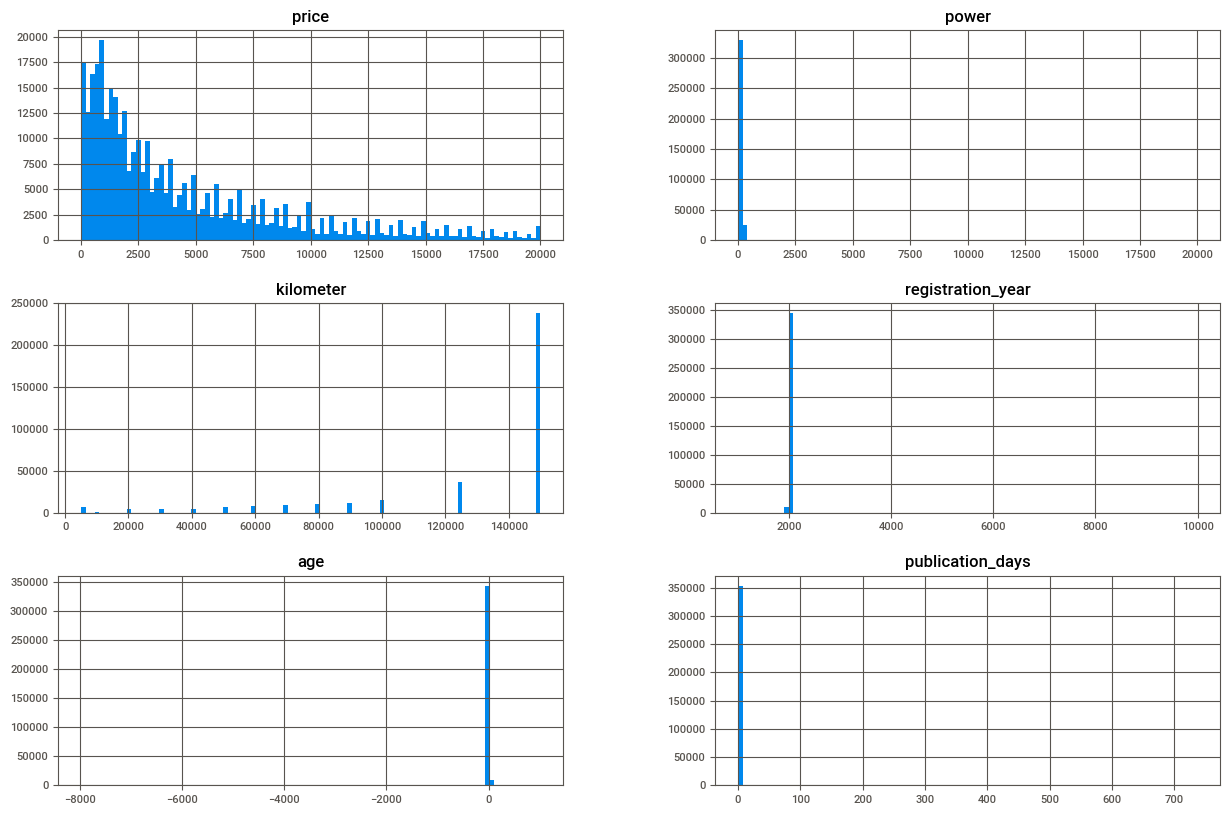

In [462]:
#Гистограммы по количественным показателям (registration_year скорее качественный, но его можно показать на гистограмме)
auto[['price', 'power', 'kilometer', 'registration_year', 'age', 'publication_days']].hist(bins=100, figsize = (15, 10));

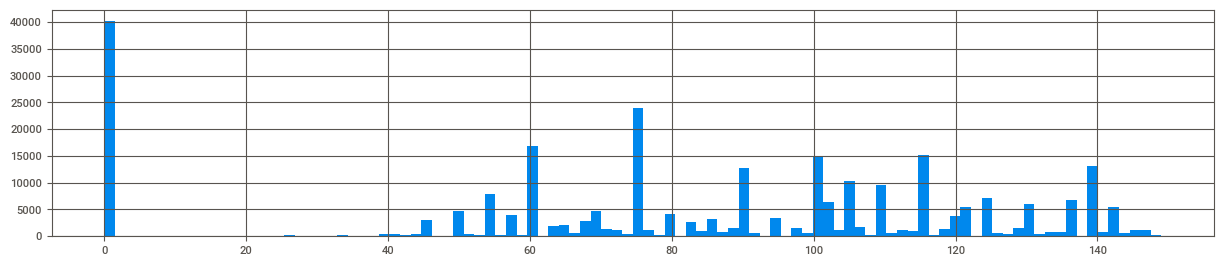

In [463]:
auto.loc[auto['power']<150, 'power'].hist(bins=100, figsize = (15, 3));

In [464]:
#Посчитаем количество строк с мощностью=0:
print(auto.loc[auto['power']==0, 'power'].count())

40225


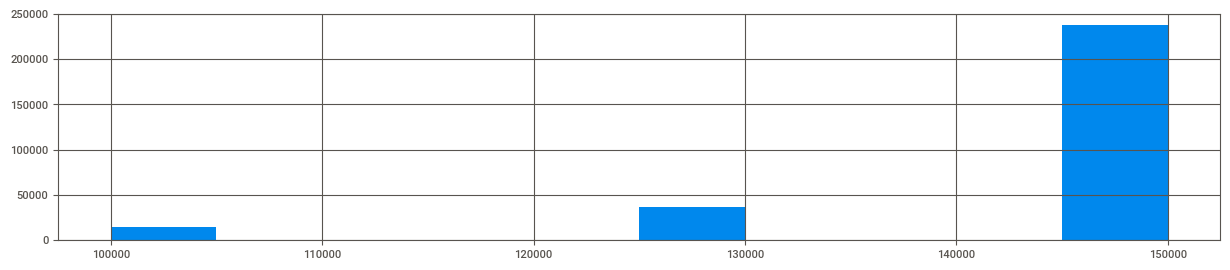

In [465]:
auto.loc[auto['kilometer']>99000, 'kilometer'].hist(figsize = (15, 3));

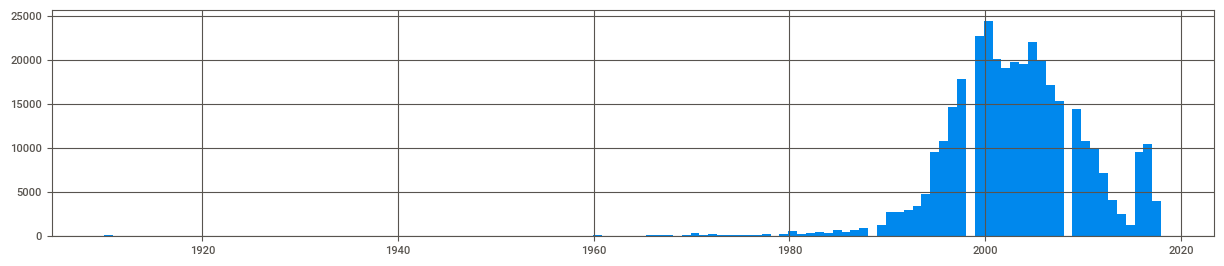

In [466]:
(auto.loc[(auto['registration_year']>=1900) & (auto['registration_year']<=2018), 'registration_year']
     .hist(bins=119, figsize = (15, 3)));

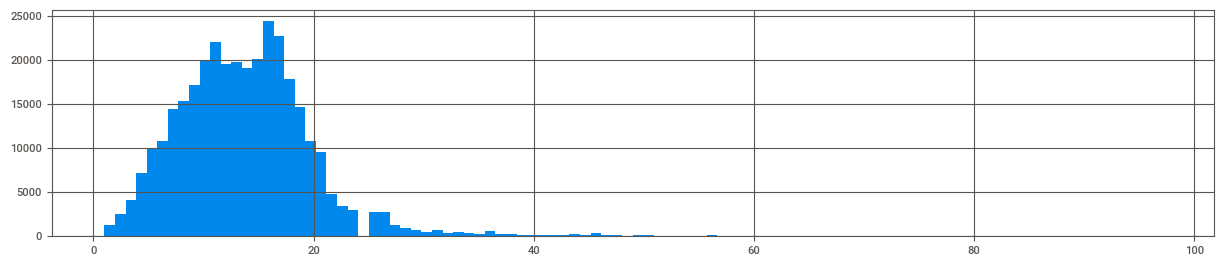

In [467]:
(auto.loc[(auto['age']>0) & (auto['age']<=100), 'age']
     .hist(bins=100, figsize = (15, 3)));

**Вывод:**

* Разброс стоимости автомобилей составляет от 0 до 20000 евро (слишком низкую и слишком высокую стоимость стоит проверить). В основном средняя стоимость составляет от 1050 до 6400 евро;
* В основном в выгрузке в основном находятся автомобили с пробегом ровно 125000 км или 150000 км, что делает показатель пробега не вполне информативным;
* Мощность автомобилей находится в диапазоне от 0 до 20000 лошадиных сил (и то, и другое значение - выбросы), но в основном в диапазоне от 69 до 143. Строки, в которых указана мощность=0, предположительно относятся к автомобилям без двигателя;
* Год регистрации автомобилей находится в диапазоне от 1000 до 9999 года (и то, и другое значение - выбросы), но в основном в диапазоне от 1999 по 2008;
* Возраст автомобиля находится в диапазоне от -7983 до 1016 лет (и то, и другое значение - выбросы, и главным образом связаны с выбросами в registration_year), но в основном в диапазоне от 8 до 17 лет

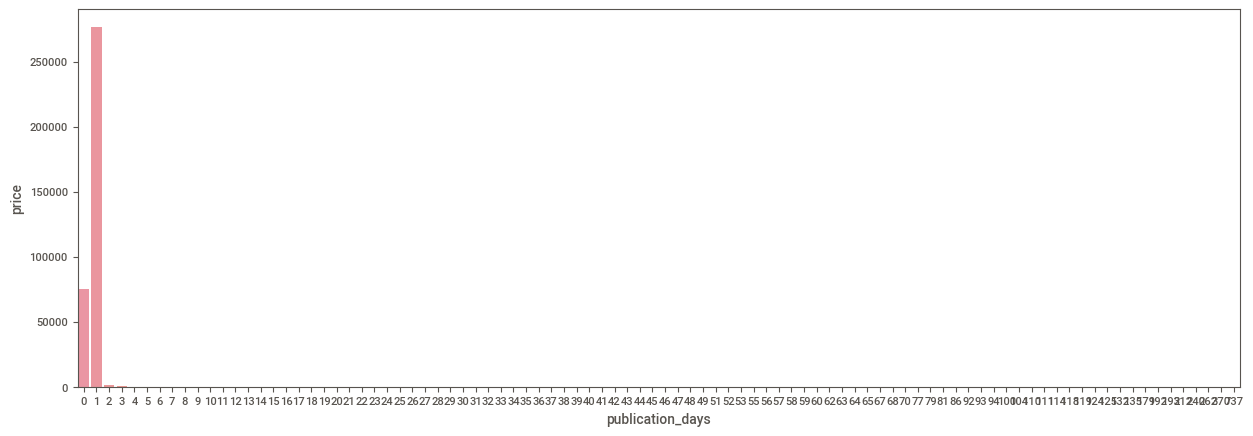

In [468]:
#Столбиковая диаграмма количества дней между датой публикации и датой выгрузки анкеты
data_column = auto.groupby('publication_days')['price'].agg('count').reset_index().sort_values(by='publication_days')
fig, ax = plt.subplots(figsize=(15, 5))
diagram = sns.barplot(data=data_column, x='publication_days', y='price')

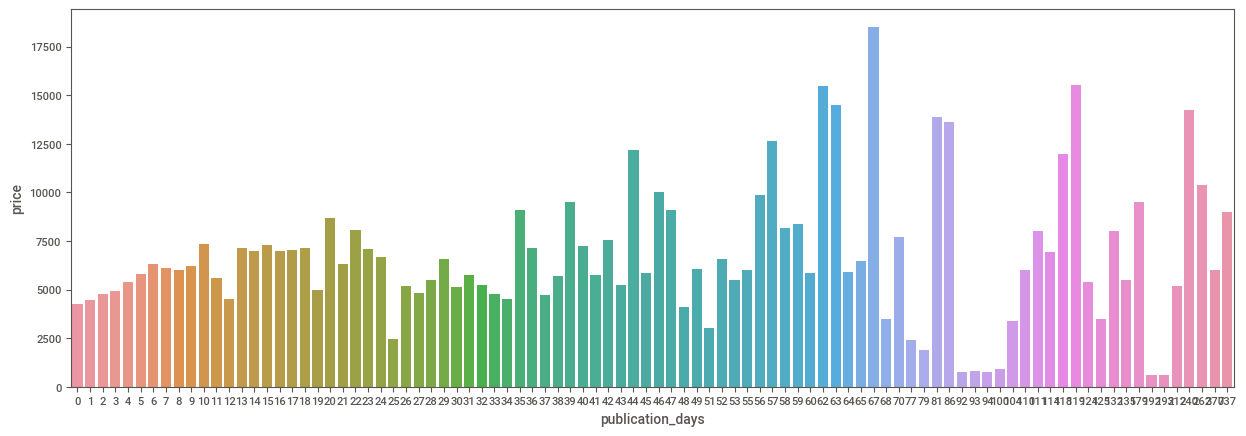

In [469]:
data_column = auto.groupby('publication_days')['price'].agg('mean').reset_index().sort_values(by='publication_days')
fig, ax = plt.subplots(figsize=(15, 5))
diagram = sns.barplot(data=data_column, x='publication_days', y='price')

**Вывод:**

* Большинство анкет были выгружены либо в день публикации, либо на следующий день, что делает неинформативным показатель разности между количеством дней публикации и датой выгрузки
* Средняя стоимость автомобиля в 0 и в 1 день после публикации не сильно отличается, а колебания средней стоимости автомобиля на 2-700 день после публикации объясняются малым количеством подобных анкет
* Таким образом, показатель date_crawled и date_created не добавляют информативности, поэтому при построении модели данные показатели можно удалить

### Обработка данных

#### Заполнение пропусков

* В данных присутствуют пропуски в показателях: vehicle_type (37490), gearbox (19833), model (19705), fuel_type (32895), repaired (71154);
* Пропущенные данные по model заполним самой популярной моделью бренда;
* Пропущенные данные в vehicle_type, gearbox, fuel_type заполним данными по аналогичной модели автомобиля, по которой такие данные есть;
* Отсутствующих данных по repaired слишком много, и поэтому строго определить их в одну из групп 'yes'/'no' нельзя. Данные по repaired без дополнительной информации восстановить невозможно, но и исключать данный признак тоже не стоит. Поэтому на этапе OHE можно закодировать пропущенные значения в качестве отдельного показателя.

In [470]:
display('Перечень всех брендов:', np.sort(auto['brand'].unique()))
display('Перечень брендов, по которым наименование модели не NaN:', 
        np.sort(auto.loc[auto['model'].isna()==False, 'brand'].unique()))

'Перечень всех брендов:'

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

'Перечень брендов, по которым наименование модели не NaN:'

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

Выявлено, что модель не проставлена для всех автомобилей sonstige_autos. sonstige_autos - это в переводе с немецкого "прочие автомобили". Поэтому заполним пропуски значением 0:

In [471]:
auto.loc[auto['brand']=='sonstige_autos','model'] = '0'

In [472]:
#Сводная таблица - бренд, самая популярная модель
#Эту сводную будем использовать для заполнения пустых значений в model
auto_models = auto.pivot_table(index=['brand', 'model'], values='price', aggfunc='count').reset_index()
auto_most_popular_models = auto_models.pivot_table(index=['brand'], values='price', aggfunc='max').reset_index()
auto_most_popular_models = auto_most_popular_models.merge(auto_models, on=['brand', 'price'])

#Заполним пустые значения model значениями самой популярной модели бренда
for brand in auto['brand'].unique():
    most_popular_model = auto_most_popular_models.loc[auto_most_popular_models['brand']==brand, 'model'].values[0]
    auto.loc[(auto['brand']==brand) & (auto['model'].isna()), 'model'] = most_popular_model

In [473]:
null_columns = ['vehicle_type', 'gearbox', 'fuel_type']

for column in null_columns:#
    #Сводная таблица - данные по column в разрезе брендов и моделей
    auto_models_column = (auto.pivot_table(index=['brand', 'model', column], 
                                          values='price', 
                                          aggfunc='count')
                             .reset_index())
    auto_most_pop_mod_col = auto_models_column.pivot_table(index=['brand', 'model'], values='price', aggfunc='max').reset_index()
    auto_most_pop_mod_col = auto_most_pop_mod_col.merge(auto_models_column, on=['brand', 'model', 'price'])
    
    #Замена пустого значения
    for brand in auto_most_pop_mod_col['brand'].unique():
        for model in auto_most_pop_mod_col.loc[auto_most_pop_mod_col['brand']==brand,'model'].unique():
            new_meaning = (auto_most_pop_mod_col.loc[(auto_most_pop_mod_col['brand']==brand) &
                                                     (auto_most_pop_mod_col['model']==model), 
                                                     column]
                                                 .values[0])
            auto.loc[(auto['brand']==brand) & 
                     (auto['model']==model) & 
                     (auto[column].isna()), 
                     column] = new_meaning
    
    #Проверка, остались ли еще в таблице пустые строки
    if auto[auto[column].isna()].shape[0] > 0:
        print('В признаке', column, 'остались пустые значения в количестве', auto[auto[column].isna()].shape[0], 'строк')

In [475]:
#Заполним пустые значения в repaired значением other
auto.loc[auto['repaired'].isna(), 'repaired'] = 'other'

#### Удаление и корректировка ошибочных значений

In [476]:
#Создадим функцию, чтобы контролировать результат:
def result_control(feature):
    #Вывод гистограммы
    auto[feature].hist(bins=200, figsize = (15, 3))
    plt.show()
    
    #Вывод статистик по столбцу
    feature_stat = auto[feature].describe().reset_index()
    feature_stat.columns = ['statistics', feature]
    
    for brand in auto['brand'].unique():
        feature_stat_brand = auto.loc[auto['brand']==brand, feature].describe().reset_index()
        feature_stat_brand.columns = ['statistics', '{}'.format(brand)]
        feature_stat = feature_stat.merge(feature_stat_brand, on='statistics')
    
    feature_stat.index = feature_stat['statistics']
    feature_stat = feature_stat.drop('statistics', axis=1)
    feature_stat = feature_stat.T.reset_index()
    feature_stat.columns = ['brand', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    
    display(feature_stat)
    
    return feature_stat

##### Удаление строк с некорректным price

In [477]:
#Сводная таблица с первыми значениями price
price_pivot_table = auto.groupby('price')['brand'].agg('count').reset_index()
price_pivot_table['percent'] = price_pivot_table['brand']/(price_pivot_table['price'].sum())
display(price_pivot_table.head())

price  brand       percent
0      0  10772  4.055622e-04
1      1   1189  4.476545e-05
2      2     12  4.517960e-07
3      3      8  3.011973e-07
4      4      1  3.764967e-08

In [478]:
#Удалим строки с price <= 1. Данные значения цены можно рассматривать как пропуски
#Price - целевой признак, и поэтому мы не сможем дозаполнить эти пропуски, пока не построим модель
auto = auto[auto['price']>1]

##### Корректировка некорректных значений power

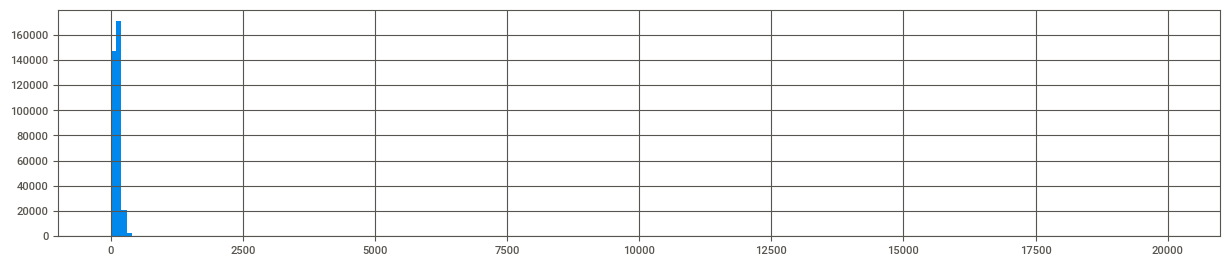

brand     count        mean         std  min     25%    50%  \
0            power  342408.0  111.097431  188.191224  0.0   69.00  105.0   
1       volkswagen   74175.0   96.484638  149.523662  0.0   61.00   90.0   
2             audi   28486.0  149.897809  217.084002  0.0  110.00  143.0   
3             jeep     655.0  161.734351   68.074857  0.0  140.00  171.0   
4            skoda    5432.0  101.507732  221.558415  0.0   75.00  101.0   
5              bmw   35650.0  159.211108  257.807744  0.0  118.00  150.0   
6          peugeot   10750.0   90.818047  115.298291  0.0   67.00   90.0   
7             ford   24387.0   94.434904  178.622290  0.0   60.00   90.0   
8            mazda    5451.0  105.827371   51.412105  0.0   88.00  110.0   
9           nissan    4798.0   92.194456   80.994128  0.0   57.00   88.0   
10         renault   17335.0   78.886934  136.588956  0.0   58.00   75.0   
11   mercedes_benz   31255.0  145.375908  214.397935  0.0  109.00  143.0   
12            opel   38375.0   92.760052  202.256190  0.0   60.00   90.0   
13            seat    6702.0   90.260668   80.609936  0.0   60.00   86.0   
14         citroen    5007.0   90.105053  179.581064  0.0   62.00   85.0   
15           honda    2707.0  105.878833   57.816695  0.0   83.00  101.0   
16            fiat    9312.0   70.758698  131.511922  0.0   54.00   65.0   
17            mini    3163.0  121.931078  119.523264  0.0   90.00  116.0   
18           smart    5163.0   61.096456  217.506877  0.0   45.00   61.0   
19         hyundai    3527.0   99.915792   51.318464  0.0   67.00  100.0   
20      alfa_romeo    2221.0  144.678073  449.788892  0.0  115.00  140.0   
21          subaru     729.0  123.241427   70.189750  0.0   86.00  124.0   
22           volvo    3115.0  138.439165   76.208565  0.0  115.00  140.0   
23      mitsubishi    2918.0  109.350240  242.024805  0.0   75.00  102.0   
24             kia    2404.0  110.952579  239.175626  0.0   75.00  113.0   
25          suzuki    2270.0   82.746696  178.958469  0.0   64.00   86.0   
26          lancia     455.0   92.850549   97.006697  0.0   60.00   80.0   
27  sonstige_autos    2759.0  106.451975  263.615170  0.0    0.00   75.0   
28          toyota    4528.0  101.445671  116.587570  0.0   69.00   97.0   
29       chevrolet    1701.0  124.853616  216.364565  0.0   67.00  113.0   
30           dacia     889.0   82.589426   36.067179  0.0   75.00   86.0   
31        daihatsu     774.0   56.114987   32.360813  0.0   43.00   58.0   
32         trabant     492.0   16.902439   17.310117  0.0    0.00   26.0   
33        chrysler    1361.0  146.922116   86.998562  0.0  131.00  146.0   
34          jaguar     488.0  207.047131   93.506656  0.0  158.25  211.0   
35          daewoo     531.0   71.094162   78.100701  0.0   52.00   75.0   
36           rover     458.0   91.801310   49.951945  0.0   75.00  103.0   
37         porsche     726.0  225.582645  119.927429  0.0  163.00  239.0   
38            saab     512.0  154.078125   54.031245  0.0  131.00  150.0   
39      land_rover     534.0  133.196629   70.017531  0.0  111.00  122.0   
40            lada     213.0   59.732394   35.867796  0.0    0.00   82.0   

      75%      max  
0   143.0  20000.0  
1   120.0  12012.0  
2   179.0  17410.0  
3   212.0    426.0  
4   122.0  16011.0  
5   192.0  19312.0  
6   116.0  10910.0  
7   116.0  15001.0  
8   136.0   1115.0  
9   117.0   2389.0  
10  107.0  10710.0  
11  177.0  20000.0  
12  120.0  17932.0  
13  110.0   4400.0  
14  110.0   9012.0  
15  140.0   1400.0  
16   90.0  10311.0  
17  136.0   6018.0  
18   71.0  10218.0  
19  140.0    999.0  
20  155.0  15033.0  
21  150.0    420.0  
22  170.0   2792.0  
23  136.0  12512.0  
24  140.0  11509.0  
25   94.0   8404.0  
26  128.0   1241.0  
27  163.0  12684.0  
28  129.0   6920.0  
29  163.0   8259.0  
30  105.0    800.0  
31   83.0    301.0  
32   26.0    236.0  
33  174.0   2000.0  
34  241.0    600.0  
35   95.0   1598.0  
36  120.0    260.0  
37  300.0    521.0  
3

In [479]:
#Исследуем power. Гипотеза: строки с power > 10000 - это строки, в которых мощность нужно поделить на 100
power_stat = result_control('power')

**Вывод:**

Из таблицы видно, что отдельные значения необходимо поделить на 100, а отдельные - на 10. По тем, где значения больше 10000 - сразу делим на 100. 
Далее определим с помощью алгоритма:
Для отдельного бренда по строкам с power больше 75% квантиля определяем: если отдельное значение, деленое на 100, попадает в межквантильный размах, то тогда делим его в таблице auto на 100. Если отдельное значение, деленое на 10, попадает в межквантильный размах, то тогда делим его на 10. 

In [480]:
auto.loc[auto['power'] >= 10000, 'power'] /= 100

for brand in auto['brand'].unique():
    quantile_0_25 = power_stat.loc[power_stat['brand']==brand, '25%'].values[0]
    quantile_0_75 = power_stat.loc[power_stat['brand']==brand, '75%'].values[0]
    
    auto.loc[(auto['brand']==brand) & 
             (auto['power'] != 0) &
             (auto['power'] >= quantile_0_25*100) & 
             (auto['power'] <= quantile_0_75*100), 
             'power'] /= 100
    
    auto.loc[(auto['brand']==brand) &
             (auto['power'] != 0) &
             (auto['power'] >= quantile_0_25*10) & 
             (auto['power'] <= quantile_0_75*10), 
             'power'] /= 10

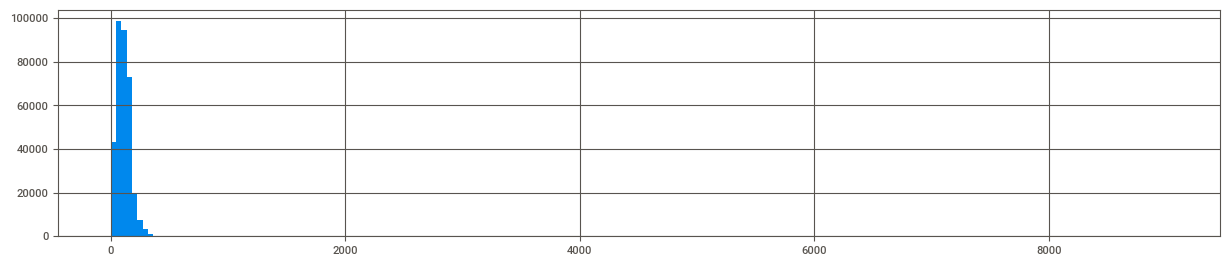

brand     count        mean         std  min     25%      50%  \
0            power  342408.0  107.697598   83.478346  0.0   69.00  105.000   
1       volkswagen   74175.0   94.803138   89.868911  0.0   61.00   90.000   
2             audi   28486.0  147.066632   91.413569  0.0  110.00  143.000   
3             jeep     655.0  161.734351   68.074857  0.0  140.00  171.000   
4            skoda    5432.0   98.589674   49.751502  0.0   75.00  101.000   
5              bmw   35650.0  155.316246   71.152360  0.0  118.00  150.000   
6          peugeot   10750.0   89.519033   46.515570  0.0   67.00   90.000   
7             ford   24387.0   91.698375   58.399270  0.0   60.00   90.000   
8            mazda    5451.0  105.643276   49.561162  0.0   88.00  110.000   
9           nissan    4798.0   92.007253   79.931125  0.0   57.00   88.000   
10         renault   17335.0   76.899276   61.019598  0.0   58.00   75.000   
11   mercedes_benz   31255.0  142.646090   96.979898  0.0  109.00  143.000   
12            opel   38375.0   89.493302   81.768871  0.0   60.00   90.000   
13            seat    6702.0   89.794017   78.234996  0.0   60.00   86.000   
14         citroen    5007.0   85.832614   67.715072  0.0   62.00   85.000   
15           honda    2707.0  104.810935   47.435821  0.0   83.00  101.000   
16            fiat    9312.0   68.663898   51.818177  0.0   54.00   65.000   
17            mini    3163.0  121.931078  119.523264  0.0   90.00  116.000   
18           smart    5163.0   55.919163   27.207257  0.0   45.00   61.000   
19         hyundai    3527.0   99.660873   49.033305  0.0   67.00  100.000   
20      alfa_romeo    2221.0  131.282094   51.080539  0.0  115.00  140.000   
21          subaru     729.0  123.241427   70.189750  0.0   86.00  124.000   
22           volvo    3115.0  138.103435   73.968579  0.0  115.00  140.000   
23      mitsubishi    2918.0  104.410356   71.327977  0.0   75.00  102.000   
24             kia    2404.0  105.689264   49.227379  0.0   75.00  113.000   
25          suzuki    2270.0   78.825789   36.803462  0.0   64.00   86.000   
26          lancia     455.0   85.605055   50.786204  0.0   60.00   77.000   
27  sonstige_autos    2759.0    0.101901    0.110063  0.0    0.00    0.075   
28          toyota    4528.0   99.730742   55.991986  0.0   69.00   97.000   
29       chevrolet    1701.0  119.691764   87.717288  0.0   67.00  113.000   
30           dacia     889.0   81.779528   26.843993  0.0   75.00   86.000   
31        daihatsu     774.0   56.114987   32.360813  0.0   43.00   58.000   
32         trabant     492.0    0.016902    0.017310  0.0    0.00    0.026   
33        chrysler    1361.0  146.922116   86.998562  0.0  131.00  146.000   
34          jaguar     488.0  207.047131   93.506656  0.0  158.25  211.000   
35          daewoo     531.0   71.094162   78.100701  0.0   52.00   75.000   
36           rover     458.0   91.801310   49.951945  0.0   75.00  103.000   
37         porsche     726.0  225.582645  119.927429  0.0  163.00  239.000   
38            saab     512.0  154.078125   54.031245  0.0  131.00  150.000   
39      land_rover     534.0  133.196629   70.017531  0.0  111.00  122.000   
40            lada     213.0    0.059732    0.035868  0.0    0.00    0.082   

        75%       max  
0   141.000  9013.000  
1   117.000  6062.000  
2   179.000  9013.000  
3   212.000   426.000  
4   122.000  1600.000  
5   192.000  2729.000  
6   116.000  1367.000  
7   116.000  1988.000  
8   136.000   428.000  
9   117.000  2389.000  
10  107.000  2018.000  
11  177.000  9000.000  
12  120.000  5867.000  
13  110.000  4400.000  
14  110.000  2000.000  
15  140.000   307.000  
16   90.000  2017.000  
17  136.000  6018.000  
18   71.000   950.000  
19  140.000   306.000  
20  155.000   260.000  
21  150.000   420.000  
22  170.000  2792.000  
23  136.000  1800.000  
24  140.000   250.000  
25   94.000   232.000  
26  128.000   220.000  
27    0.163     1.324  
28  129.000  1521.000  
29  163.000  165

In [481]:
power_stat = result_control('power')

**Вывод:**

Отдельные выбросы все равно остались, но их немного и поэтому они будут удалены на этапе удаления аномалий

##### Корректировка некорректных значений registration_year и age

<AxesSubplot:>

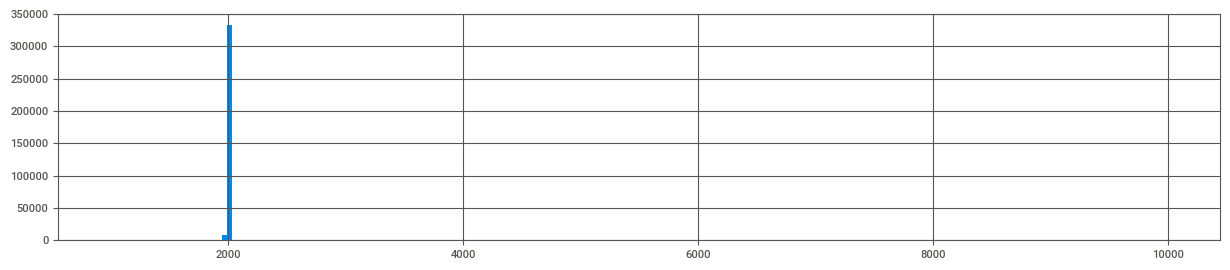

In [482]:
auto['registration_year'].hist(bins=200, figsize=(15, 3))

In [483]:
#Исследуем registration_year и age
print('Уникальные года регистрации:', np.sort(auto['registration_year'].unique()))
print('Самая поздняя дата выгрузки анкеты:', auto['date_crawled'].max())

Уникальные года регистрации: [1000 1001 1039 1111 1234 1255 1300 1400 1500 1600 1602 1800 1910 1923
 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940
 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2222 2290 2500
 2800 2900 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600
 5900 5911 6000 7000 7100 7800 8000 8200 8500 8888 9000 9450 9999]
Самая поздняя дата выгрузки анкеты: 2016-04-07 14:36:58


**Вывод:**

* В данных есть ошибки - предположительно, автомобили с годом регистрации, например, 6000, 7100 - это автомобили, зарегистрированные в 1960 и 1971 годах. Поэтому всем автомобилям с годом регистрации, заканчивающимся на 00 (кроме 1900 и 2000), изменим дату регистрации соответствующим образом;
* В данных не могут быть автомобили, зарегистрированные ранее 1884 года (дата патента на автомобили с ДВС https://ru.wikipedia.org/wiki/%D0%98%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8F ) и позже 2016 года, так как это дата выгрузки, и мы не можем знать об автомобилях, которые будут зарегистрированы в будущем. 

In [484]:
#Изменим год регистрации
list_of_years_1900 = [2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5600,
                 5900, 6000, 6500, 7000, 7100, 7800, 8000, 8200, 8500, 9000]
list_of_years_2000 = [1000, 1300, 1400, 1500, 1600, 1800] 
    
auto.loc[auto['registration_year'].isin(list_of_years_1900), 'registration_year'] = (1900 
    + auto.loc[auto['registration_year'].isin(list_of_years_1900), 'registration_year'] / 100)
auto.loc[auto['registration_year'].isin(list_of_years_2000), 'registration_year'] = (2000 
    + auto.loc[auto['registration_year'].isin(list_of_years_2000), 'registration_year'] / 100)

auto['registration_year'] = auto['registration_year'].astype('int')

#Изменим значение age
auto['age'] = pd.DatetimeIndex(auto['date_crawled']).year - auto['registration_year']

In [485]:
print('Количество оставшихся строк с годом регистрации меньше чем 1900 и больше 2020:',
      auto.loc[(auto['registration_year']<1900) | (auto['registration_year']>2020), 'registration_year'].count())

Количество оставшихся строк с годом регистрации меньше чем 1900 и больше 2020: 37


In [486]:
#Строк с годом регистрации меньше чем 1900 и больше 2020 очень мало, поэтому проще удалить их, чем исправлять дальше
auto = auto[(auto['registration_year']>1900) & (auto['registration_year']<2020)]

#Строк с годом регистрации больше, чем 2016 не должно быть в выгрузке, так как 2016 - это дата выгрузки анкеты
auto = auto[auto['registration_year']<=2016]

#### Устранение аномалий

Аномалии и ошибки будем искать в признаках: 'price', 'power', 'registration_year' и 'age'. Аномалии в признаках 'registration_year' и 'age' будем исправлять одновременно, так как 'age' рассчитывается на основе значений в 'registration_year'

In [487]:
auto_shape_before = auto.shape
print(auto_shape_before)

(328736, 18)


In [488]:
auto[['price', 'power', 'registration_year', 'age']].describe()

price          power  registration_year            age
count  328736.000000  328736.000000      328736.000000  328736.000000
mean     4622.288904     108.683203        2002.601324      13.398676
std      4546.065260      81.361538           6.928423       6.928423
min         2.000000       0.000000        1910.000000       0.000000
25%      1200.000000      69.000000        1999.000000       9.000000
50%      2950.000000     105.000000        2003.000000      13.000000
75%      6666.000000     143.000000        2007.000000      17.000000
max     20000.000000    9013.000000        2016.000000     106.000000

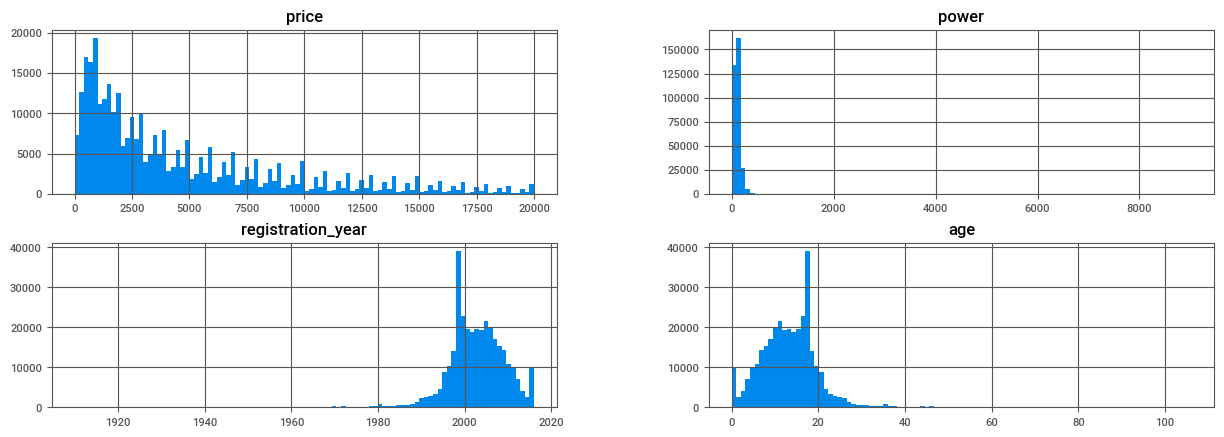

In [489]:
auto[['price', 'power', 'registration_year', 'age']].hist(bins=100, figsize=(15, 5));

##### Устранение аномалий в price

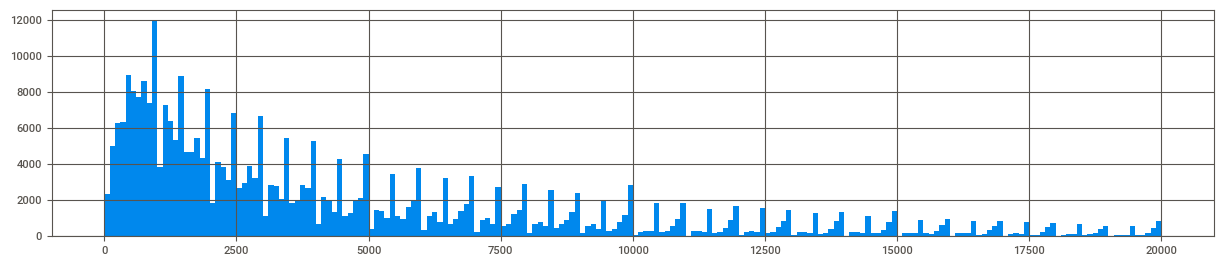

brand     count          mean          std    min     25%  \
0            price  328736.0   4622.288904  4546.065260    2.0  1200.0   
1       volkswagen   70614.0   4601.206163  4497.528258    5.0  1249.0   
2             audi   27569.0   6515.636476  5266.522661    2.0  2000.0   
3             jeep     632.0   7401.533228  4826.950535   35.0  3600.0   
4            skoda    5297.0   6022.987540  4469.786826    9.0  2490.0   
5              bmw   34614.0   6427.961750  5027.400892    2.0  2205.5   
6          peugeot   10397.0   3218.122632  3131.193683    8.0  1000.0   
7             ford   23443.0   3298.657680  3884.157603    5.0   799.0   
8            mazda    5243.0   3770.695403  3797.888470    3.0  1000.0   
9           nissan    4611.0   4255.537844  4761.686717   10.0   899.0   
10         renault   16384.0   2377.267151  2793.243020    2.0   749.0   
11   mercedes_benz   30259.0   6103.280445  5030.596020    2.0  2000.0   
12            seat    6342.0   4174.281615  4074.372055    2.0  1000.0   
13           honda    2585.0   3848.906770  3764.689898   30.0  1000.0   
14            fiat    8859.0   2814.576250  3004.444417    5.0   750.0   
15            opel   36559.0   2869.304385  3233.250311    2.0   790.0   
16            mini    3059.0   9208.211507  4577.450252    9.0  5500.0   
17           smart    4957.0   3592.123865  2457.150838    2.0  1800.0   
18         hyundai    3392.0   5254.837854  4469.621560   11.0  1750.0   
19      alfa_romeo    2145.0   3880.661072  3872.387160   10.0  1111.0   
20          subaru     714.0   3844.567227  4437.555055   20.0   799.0   
21           volvo    3049.0   4426.489013  4601.620461   10.0  1000.0   
22      mitsubishi    2808.0   3051.316239  3556.062592   10.0   750.0   
23             kia    2304.0   5148.612847  4619.576587   25.0  1650.0   
24          suzuki    2199.0   3977.540246  3579.860865   50.0  1150.0   
25          lancia     436.0   2428.662844  3143.810183   10.0   650.0   
26         citroen    4789.0   3593.946127  3405.104344   10.0  1200.0   
27  sonstige_autos    2650.0   6268.950189  5482.771385    2.0  1690.0   
28          toyota    4387.0   4867.124459  3741.803879   30.0  1999.0   
29       chevrolet    1654.0   5855.493349  4628.656865   50.0  2253.0   
30           dacia     864.0   5929.716435  3667.967478   30.0  2900.0   
31        daihatsu     748.0   1777.469251  1902.345356   30.0   550.0   
32         trabant     482.0   1925.427386  2116.880130   10.0   550.0   
33        chrysler    1320.0   3919.160606  3985.514768    5.0  1000.0   
34          jaguar     483.0   6921.329193  5282.837637   50.0  2870.0   
35          daewoo     503.0   1031.924453   621.434084   10.0   550.0   
36           rover     433.0   1401.133949  1629.309050   50.0   550.0   
37         porsche     717.0  11466.294282  5502.775043    8.0  7950.0   
38            saab     501.0   3820.836327  3820.557569  150.0  1100.0   
39      land_rover     527.0   8631.603416  5532.600574   25.0  3600.0   
40            lada     207.0   3191.425121  2255.586739   99.0  1499.5   

        50%       75%      max  
0    2950.0   6666.00  20000.0  
1    2900.0   6700.00  20000.0  
2    4999.0   9999.00  20000.0  
3    6249.5   9995.25  20000.0  
4    4900.0   8500.00  20000.0  
5    5000.0   9599.00  20000.0  
6    2300.0   4200.00  20000.0  
7    1720.0   4200.00  20000.0  
8    2498.0   5100.00  20000.0  
9    2000.0   5950.00  20000.0  
10   1350.0   2950.00  20000.0  
11   4500.0   8888.00  20000.0  
12   2700.0   6250.00  20000.0  
13   2450.0   5600.00  20000.0  
14   1600.0   3900.00  20000.0  
15   1600.0   3800.00  20000.0  
16   8499.0  12500.00  20000.0  
17   2950.0   4900.00  20000.0  
18   3999.0   7300.00  19999.0  
19   2400.0   5500.00  20000.0  
20   1800.0   5500.00  20000.0  
21   2500.0   6250.00  20000.0  
22   1650.0   3999.00  20000.0  
23   3594.5   7000.00  20000.0  
24   2999.0   5500.00  19800.0  
25   1190.0   2950.00  19500.0  
26   2500.0  

In [490]:
price_stat = result_control('price')

**Вывод:**
* График сильно скошен вправо. Поэтому есть смысл убрать больше выбросов справа, чем слева. Тем не менее, слева тоже много аномально низких значений (например 0 евро), которые нужно удалить
* На графике видны равные расстояния между стоимостями с большим количеством соответствующих автомобилей - это связано с тем, что клиенты любят ставить ровную цену за автомобиль
* Из выведенных статистик видно, что выбросы есть в каждом бренде автомобилей. При этом у каждого бренда свой диапазон нормальной стоимости автомобиля, что необходимо учитывать
* Уберем 5% аномально низких значений слева, и 1% справа

In [491]:
for brand in auto['brand'].unique():
    min_quantile = auto.loc[auto['brand']==brand, 'price'].quantile(0.05)
    max_quantile = auto.loc[auto['brand']==brand, 'price'].quantile(0.99)
    auto = auto[(auto['brand']!=brand) | 
                ((auto['brand']==brand) & (auto['price']>=min_quantile) & (auto['price']<=max_quantile))] 

In [492]:
print('Потеря данных после удаления строк составила', (1 - auto.shape[0]/auto_shape_before[0])*100, '%')

Потеря данных после удаления строк составила 5.744427139102504 %


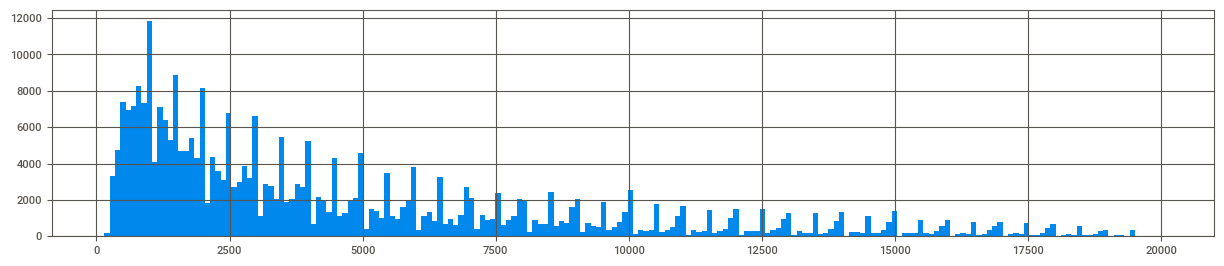

brand     count          mean          std     min      25%  \
0            price  309852.0   4695.340759  4344.803393   150.0  1399.00   
1       volkswagen   66403.0   4676.151153  4262.798793   380.0  1400.00   
2             audi   25984.0   6682.375231  5060.440652   600.0  2350.00   
3             jeep     594.0   7626.856902  4566.730290  1450.0  3990.00   
4            skoda    4983.0   6185.064218  4223.500202   890.0  2775.00   
5              bmw   32663.0   6629.143741  4837.234987   650.0  2500.00   
6          peugeot    9864.0   3199.990876  2790.858514   350.0  1200.00   
7             ford   22046.0   3302.238683  3603.210594   220.0   890.00   
8            mazda    4964.0   3771.934126  3497.810034   350.0  1150.00   
9           nissan    4335.0   4305.826298  4552.514780   300.0   999.00   
10         renault   15471.0   2341.076207  2430.221514   250.0   800.00   
11   mercedes_benz   28451.0   6252.823837  4820.368627   799.0  2400.00   
12            seat    5968.0   4225.553787  3805.201986   350.0  1200.00   
13           honda    2436.0   3881.916256  3500.547525   450.0  1199.00   
14            fiat    8372.0   2810.746297  2715.985796   250.0   850.00   
15            opel   34596.0   2837.070817  2886.387140   250.0   850.00   
16            mini    2888.0   9434.520776  4296.247812  3200.0  5996.75   
17           smart    4688.0   3615.502560  2141.252529   800.0  1900.00   
18         hyundai    3191.0   5363.722344  4231.101884   550.0  1990.00   
19          subaru     675.0   3883.371852  4229.199311   250.0   850.00   
20           volvo    2874.0   4471.564022  4371.559141   400.0  1199.25   
21      mitsubishi    2638.0   3031.910538  3209.301832   299.0   850.00   
22      alfa_romeo    2018.0   3925.821110  3607.604163   370.0  1299.25   
23             kia    2172.0   5228.521179  4382.377941   550.0  1850.00   
24          suzuki    2080.0   4018.915865  3330.955556   300.0  1299.00   
25          lancia     414.0   2343.541063  2729.445219   200.0   700.00   
26         citroen    4511.0   3618.044114  3101.370855   350.0  1350.00   
27          toyota    4130.0   4938.428571  3427.504220   800.0  2300.00   
28       chevrolet    1554.0   5984.709781  4378.109648   895.0  2492.25   
29           dacia     812.0   6066.667488  3420.003696  1500.0  3000.00   
30  sonstige_autos    2490.0   6448.610442  5281.531082   299.0  2000.00   
31        daihatsu     702.0   1772.980057  1702.706760   175.0   612.50   
32        chrysler    1255.0   3919.074900  3725.558460   400.0  1200.00   
33          jaguar     453.0   7115.525386  5073.760678  1199.0  3100.00   
34          daewoo     478.0   1042.198745   563.553175   200.0   599.00   
35           rover     411.0   1322.639903  1088.712729   200.0   599.00   
36         porsche     673.0  11971.534918  4924.326588   500.0  8800.00   
37            saab     474.0   3855.732068  3553.316403   500.0  1212.50   
38         trabant     452.0   1906.719027  1791.360818   150.0   600.00   
39      land_rover     496.0   8907.989919  5311.746829  1750.0  3900.00   
40            lada     193.0   3225.590674  1975.604550   600.0  1600.00   

        50%      75%      max  
0    3000.0   6800.0  19999.0  
1    3000.0   6850.0  18700.0  
2    5300.0  10000.0  19500.0  
3    6500.0   9999.0  19500.0  
4    5000.0   8600.0  18500.0  
5    5500.0   9800.0  19500.0  
6    2400.0   4200.0  15900.0  
7    1850.0   4300.0  17500.0  
8    2500.0   5200.0  16980.0  
9    2200.0   6000.0  18500.0  
10   1450.0   2990.0  14500.0  
11   4750.0   8950.0  19750.0  
12   2900.0   6400.0  18000.0  
13   2500.0   5700.0  16500.0  
14   1700.0   3950.0  13900.0  
15   1700.0   3800.0  15600.0  
16   8599.0  12500.0  19750.0  
17   2999.0   4950.0  11900.0  
18   4200.0   7499.0  18000.0  
19   1900.0   5650.0  18500.0  
20   2800.0   6300.0  18800.0  
21   1790.0   4100.0  17000.0  
22   2500.0   5600.0  17500.0  
23   3800.0   7150.0  18980.0  
24   3169.5   5612.5

In [493]:
price_stat = result_control('price')

##### Устранение аномалий в power

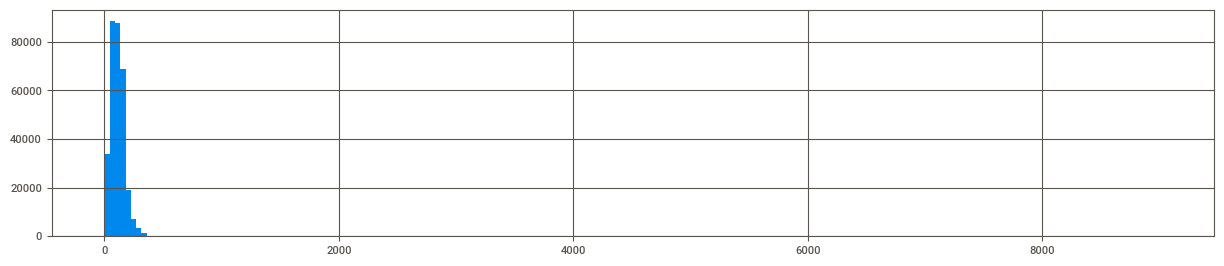

brand     count        mean         std  min     25%      50%  \
0            power  309852.0  110.287813   79.621829  0.0   75.00  105.000   
1       volkswagen   66403.0   96.931653   81.714519  0.0   69.00  101.000   
2             audi   25984.0  150.152959   92.110477  0.0  116.00  150.000   
3             jeep     594.0  166.680135   62.005211  0.0  140.00  176.000   
4            skoda    4983.0  100.663656   48.884794  0.0   75.00  102.000   
5              bmw   32663.0  158.941683   67.910489  0.0  122.00  163.000   
6          peugeot    9864.0   91.633972   45.332153  0.0   68.00   95.000   
7             ford   22046.0   93.769676   57.435417  0.0   60.00   95.000   
8            mazda    4964.0  108.183421   47.796293  0.0   88.00  110.000   
9           nissan    4335.0   94.812687   81.098833  0.0   60.00   90.000   
10         renault   15471.0   79.041167   61.370434  0.0   58.00   75.000   
11   mercedes_benz   28451.0  145.865294   78.559577  0.0  110.00  143.000   
12            seat    5968.0   91.606820   76.347639  0.0   60.00   86.000   
13           honda    2436.0  106.875698   45.550732  0.0   83.00  105.000   
14            fiat    8372.0   70.378669   52.153188  0.0   55.00   69.000   
15            opel   34596.0   91.449119   82.725151  0.0   60.00   90.000   
16            mini    2888.0  124.097299  123.885630  0.0   95.00  116.000   
17           smart    4688.0   57.433759   26.258928  0.0   45.00   61.000   
18         hyundai    3191.0  101.981793   46.442378  0.0   68.00  103.000   
19          subaru     675.0  125.026667   68.084272  0.0   86.00  125.000   
20           volvo    2874.0  141.098887   73.563831  0.0  116.00  140.000   
21      mitsubishi    2638.0  104.488787   55.026406  0.0   76.25  103.000   
22      alfa_romeo    2018.0  134.079549   48.321280  0.0  116.00  140.000   
23             kia    2172.0  107.742169   47.723199  0.0   75.00  114.000   
24          suzuki    2080.0   80.354106   35.639325  0.0   68.00   86.000   
25          lancia     414.0   87.515217   49.825452  0.0   60.00   80.000   
26         citroen    4511.0   87.591394   66.023326  0.0   68.00   88.000   
27          toyota    4130.0  101.806247   55.747510  0.0   69.00   99.000   
28       chevrolet    1554.0  120.058359   85.002260  0.0   68.00  120.000   
29           dacia     812.0   82.672414   25.912897  0.0   75.00   86.000   
30  sonstige_autos    2490.0    0.106492    0.108791  0.0    0.00    0.090   
31        daihatsu     702.0   57.598291   31.710457  0.0   50.00   58.000   
32        chrysler    1255.0  147.657371   68.141591  0.0  133.00  147.000   
33          jaguar     453.0  212.035320   89.570305  0.0  170.00  211.000   
34          daewoo     478.0   72.930962   80.652589  0.0   52.00   75.000   
35           rover     411.0   94.082725   48.971549  0.0   75.00  105.000   
36         porsche     673.0  235.496285  111.576956  0.0  190.00  245.000   
37            saab     474.0  155.040084   53.996129  0.0  131.00  150.000   
38         trabant     452.0    0.017440    0.017391  0.0    0.00    0.026   
39      land_rover     496.0  135.352823   69.056780  0.0  111.00  122.000   
40            lada     193.0    0.062663    0.034250  0.0    0.06    0.082   

        75%       max  
0   143.000  9013.000  
1   122.000  6062.000  
2   179.000  9013.000  
3   212.000   426.000  
4   125.000  1600.000  
5   192.000  2729.000  
6   120.000  1367.000  
7   120.000  1988.000  
8   136.000   328.000  
9   117.000  2389.000  
10  107.000  2018.000  
11  177.000  3454.000  
12  110.000  4400.000  
13  140.000   295.000  
14   90.000  2017.000  
15  120.000  5867.000  
16  143.000  6018.000  
17   71.000   950.000  
18  140.000   306.000  
19  150.000   420.000  
20  170.000  2792.000  
21  136.000  1363.000  
22  155.000   260.000  
23  140.000   250.000  
24   95.000   232.000  
25  128.000   220.000  
26  110.000  2000.000  
27  129.000  1521.000  
28  163.000  1659.000  
29  105.000   12

In [494]:
power_stat = result_control('power')

**Вывод:**

* График сильно скошен вправо. Поэтому есть смысл убрать больше выбросов справа, чем слева;
* Из выведенных статистик видно, что выбросы есть в каждом бренде автомобилей. При этом у каждого бренда свой диапазон нормальной стоимости автомобиля, что необходимо учитывать;
* Уберем 1% аномально низких значений слева, и 4% справа

In [495]:
for brand in auto['brand'].unique():
    min_quantile = auto.loc[auto['brand']==brand, 'power'].quantile(0.01)
    max_quantile = auto.loc[auto['brand']==brand, 'power'].quantile(0.96)
    auto = auto[(auto['brand']!=brand) | 
                ((auto['brand']==brand) & (auto['power']>min_quantile) & (auto['power']<max_quantile))] 

In [496]:
print('Потеря данных после удаления строк составила', (1 - auto.shape[0]/auto_shape_before[0])*100, '%')

Потеря данных после удаления строк составила 18.381923488756936 %


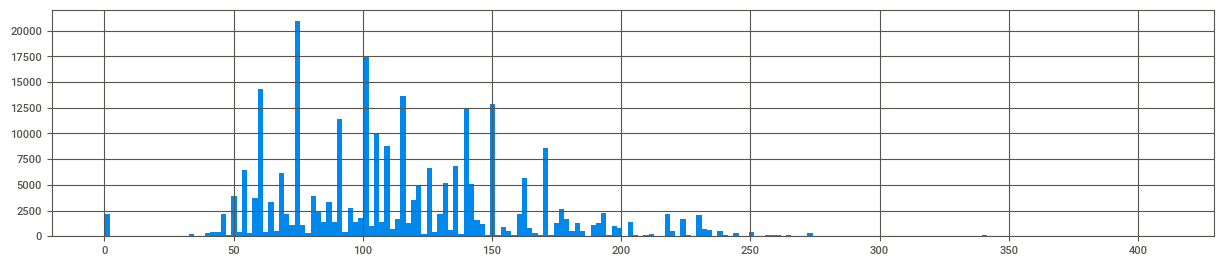

brand     count        mean        std      min      25%  \
0            power  268308.0  114.499745  46.023702    0.001   75.000   
1             audi   23275.0  152.209430  41.298168    1.000  125.000   
2             jeep     532.0  173.216165  39.006498   45.000  150.000   
3       volkswagen   58030.0   98.832682  32.648736    1.000   75.000   
4            skoda    4257.0   98.531830  28.630981   10.000   75.000   
5              bmw   29207.0  161.967856  38.263574    3.000  136.000   
6          peugeot    8583.0   96.290516  27.398181    7.000   75.000   
7             ford   18850.0   98.932269  30.008432    4.000   75.000   
8            mazda    4307.0  113.838519  26.466916    1.000   98.000   
9          renault   12536.0   85.198859  26.077420    1.000   58.000   
10   mercedes_benz   24820.0  151.730116  43.983098    1.000  122.000   
11            seat    5210.0   90.211036  30.105914    5.000   64.000   
12           honda    2132.0  110.788555  28.040471    7.000   90.000   
13            fiat    6970.0   75.543217  23.200391    1.000   60.000   
14            opel   29631.0   95.664824  31.068418    1.000   72.000   
15            mini    2696.0  120.635015  32.360337   34.000   95.000   
16           smart    4093.0   60.669059  12.462842    1.000   54.000   
17         hyundai    2832.0  106.002083  33.730775    2.000   75.000   
18          nissan    3658.0   97.475943  33.362324   13.000   65.000   
19          subaru     576.0  126.718750  44.202586   25.000   94.000   
20           volvo    2566.0  144.224942  31.548644   45.000  116.000   
21      mitsubishi    2242.0  111.580919  28.115028   55.000   90.000   
22      alfa_romeo    1801.0  139.853154  28.072554   50.000  120.000   
23          suzuki    1781.0   85.993565  20.764382   26.000   69.000   
24          lancia     352.0   93.338920  36.068928   44.000   60.000   
25         citroen    3832.0   91.176352  27.006642    4.000   68.000   
26          toyota    3435.0  101.201689  28.231167   48.000   75.000   
27             kia    1878.0  113.599036  31.227780   25.000   88.000   
28       chevrolet    1315.0  124.427901  53.138476   45.000   72.000   
29           dacia     706.0   86.971671  12.466433   68.000   75.000   
30  sonstige_autos    1694.0    0.133752   0.081938    0.001    0.068   
31        daihatsu     554.0   65.747292  16.643405   30.000   56.000   
32        chrysler    1061.0  159.123468  35.942943    1.000  140.000   
33          jaguar     391.0  218.994885  48.598617  120.000  196.000   
34          daewoo     368.0   81.160326  23.656346   45.000   60.000   
35           rover     323.0  105.727554  24.462294   16.000   84.000   
36         porsche     575.0  245.015652  72.156779    2.000  204.000   
37            saab     422.0  156.966825  30.815424   63.000  136.000   
38         trabant     262.0    0.025798   0.001460    0.019    0.026   
39      land_rover     412.0  143.133495  41.085149   12.000  113.000   
40            lada     143.0    0.078951   0.008091    0.045    0.080   

        50%      75%      max  
0   109.000  143.000  409.000  
1   150.000  179.000  264.000  
2   177.000  212.000  235.000  
3   101.000  116.000  178.000  
4   101.000  110.000  168.000  
5   163.000  192.000  271.000  
6   101.000  112.000  155.000  
7   101.000  118.000  171.000  
8   110.000  136.000  190.000  
9    75.000  107.000  149.000  
10  150.000  177.000  277.000  
11   86.000  105.000  169.000  
12  105.000  140.000  185.000  
13   69.000   90.000  132.000  
14   97.000  120.000  165.000  
15  116.000  122.750  193.000  
16   61.000   71.000   90.000  
17  103.000  139.250  172.000  
18   97.000  117.000  179.000  
19  125.000  150.000  264.000  
20  140.000  170.000  219.000  
21  109.000  136.000  167.000  
22  144.000  155.000  208.000  
23   86.000   94.000  135.000  
24   80.000  128.000  181.000  
25   90.000  109.000  155.000  
26   97.000  126.000  176.000  
27  116.000  140.000  184.000  
28  122.000  163.0

In [497]:
power_stat = result_control('power')

##### Удаление аномалий в registration_year и age

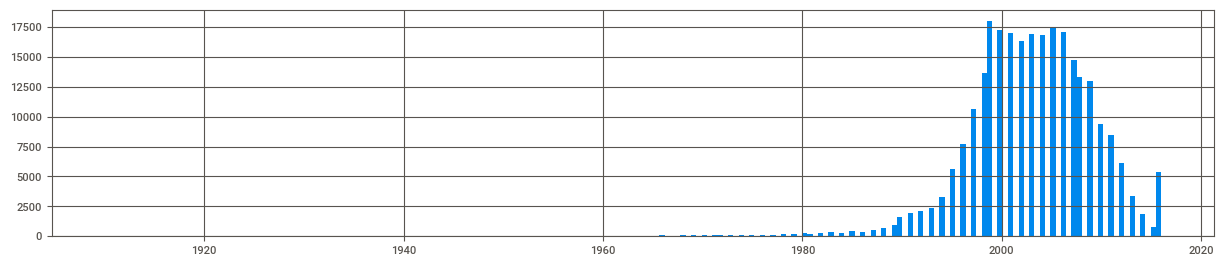

brand     count         mean        std     min     25%  \
0   registration_year  268308.0  2002.865602   6.451428  1910.0  1999.0   
1                audi   23275.0  2003.277035   5.761440  1954.0  1999.0   
2                jeep     532.0  1999.646617  10.468459  1942.0  1996.0   
3          volkswagen   58030.0  2002.362244   6.808203  1910.0  1998.0   
4               skoda    4257.0  2006.950904   4.580697  1960.0  2004.0   
5                 bmw   29207.0  2002.562365   5.628931  1929.0  1999.0   
6             peugeot    8583.0  2003.914249   5.047605  1910.0  2001.0   
7                ford   18850.0  2003.328912   6.014205  1927.0  2000.0   
8               mazda    4307.0  2002.761087   5.394109  1960.0  1999.0   
9             renault   12536.0  2002.894464   5.277987  1910.0  1999.0   
10      mercedes_benz   24820.0  2001.656567   6.768458  1937.0  1999.0   
11               seat    5210.0  2004.733589   5.262366  1977.0  2000.0   
12              honda    2132.0  2001.721857   6.381654  1971.0  1997.0   
13               fiat    6970.0  2003.505595   7.064127  1952.0  2000.0   
14               opel   29631.0  2002.345415   6.144117  1929.0  1999.0   
15               mini    2696.0  2007.261869   4.067479  1967.0  2005.0   
16              smart    4093.0  2005.582702   4.370188  1992.0  2002.0   
17            hyundai    2832.0  2007.207627   4.430790  1991.0  2004.0   
18             nissan    3658.0  2003.513395   5.903421  1977.0  2000.0   
19             subaru     576.0  2000.989583   5.727726  1961.0  1997.0   
20              volvo    2566.0  2001.100546   7.204343  1956.0  1998.0   
21         mitsubishi    2242.0  2002.434880   5.463644  1984.0  1999.0   
22         alfa_romeo    1801.0  2002.660744   6.674567  1950.0  2001.0   
23             suzuki    1781.0  2003.586749   6.626718  1980.0  1999.0   
24             lancia     352.0  2000.465909   7.520455  1960.0  1998.0   
25            citroen    3832.0  2004.434760   6.237066  1923.0  2002.0   
26             toyota    3435.0  2004.457351   5.500794  1976.0  2001.0   
27                kia    1878.0  2006.958999   4.047523  1994.0  2004.0   
28          chevrolet    1315.0  2004.404563   9.522335  1954.0  2005.0   
29              dacia     706.0  2010.284703   2.443046  1990.0  2009.0   
30     sonstige_autos    1694.0  1994.274498  15.872598  1929.0  1984.0   
31           daihatsu     554.0  2002.483755   4.853804  1985.0  1999.0   
32           chrysler    1061.0  2001.690858   5.395718  1949.0  1999.0   
33             jaguar     391.0  2000.593350   7.515513  1965.0  1999.0   
34             daewoo     368.0  2002.105978   3.178978  1996.0  2000.0   
35              rover     323.0  1999.699690   4.385135  1972.0  1998.0   
36            porsche     575.0  1997.737391   9.354176  1968.0  1991.5   
37               saab     422.0  1999.495261   5.588734  1976.0  1997.0   
38            trabant     262.0  1982.629771   8.807235  1958.0  1980.0   
39         land_rover     412.0  2001.099515   8.100782  1960.0  1999.0   
40               lada     143.0  2001.965035  11.067916  1973.0  1999.5   

       50%      75%     max  
0   2003.0  2007.00  2016.0  
1   2004.0  2007.00  2016.0  
2   2001.0  2006.00  2016.0  
3   2002.0  2007.00  2016.0  
4   2007.0  2010.00  2016.0  
5   2003.0  2007.00  2016.0  
6   2004.0  2007.00  2016.0  
7   2003.0  2007.00  2016.0  
8   2003.0  2006.00  2016.0  
9   2002.0  2006.00  2016.0  
10  2002.0  2006.00  2016.0  
11  2004.0  2009.00  2016.0  
12  2001.0  2006.25  2016.0  
13  2003.0  2008.00  2016.0  
14  2002.0  2006.00  2016.0  
15  2008.0  2010.00  2016.0  
16  2005.0  2009.00  2016.0  
17  2008.0  2011.00  2016.0  
18  2003.0  2008.00  2016.0  
19  2000.0  2005.00  2016.0  
20  2001.0  2006.00  2016.0  
21  2002.0  2006.00  2016.0  
22  2003.0  2006.00  2016.0  
23  2005.0  2008.00  2016.0  
24  2000.5  2004.00  2016.0  
25  2005.0  2008.00  2016.0  
26  2005.0  2008.00  2016.0  
27  2006.0  2010.00  2016

In [498]:
reg_year_stat = result_control('registration_year')

**Вывод:**
* График скошен влево. На этапе удаления ошибочных значений мы удалили все автомобили с датой регистрации большей, чем 2016 год (дата выгрузки анкет), поэтому график заканчивается на 2016 г;
* На графике видно, что количество автомобилей, зарегистрированных в 2016 году резко выросло. Это может быть связано с ошибкой;
* Удалим 4% слева и 1% справа.

In [499]:
for brand in auto['brand'].unique():
    min_quantile = auto.loc[auto['brand']==brand, 'registration_year'].quantile(0.04)
    max_quantile = auto.loc[auto['brand']==brand, 'registration_year'].quantile(0.99)
    auto = auto[(auto['brand']!=brand) | 
                ((auto['brand']==brand) & 
                 (auto['registration_year']>=min_quantile) &
                 (auto['registration_year']<=max_quantile))] 

auto['registration_year'] = auto['registration_year'].astype('int')

In [500]:
print('Потеря данных после удаления строк составила', (1 - auto.shape[0]/auto_shape_before[0])*100, '%')

Потеря данных после удаления строк составила 21.293682468607035 %


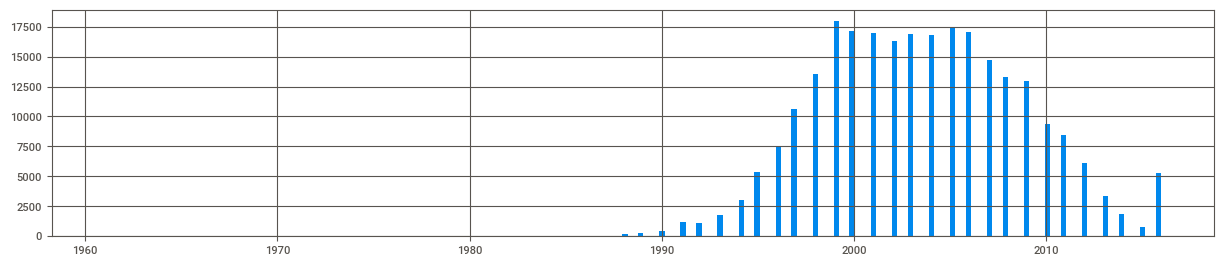

brand     count         mean        std     min      25%  \
0   registration_year  258736.0  2003.473676   5.441462  1961.0  2000.00   
1                audi   22402.0  2003.836041   5.031585  1993.0  2000.00   
2                jeep     506.0  2001.027668   6.512990  1979.0  1997.00   
3          volkswagen   55815.0  2003.055541   5.799489  1991.0  1999.00   
4               skoda    4188.0  2007.175979   4.075339  1999.0  2004.00   
5                 bmw   28059.0  2003.151324   4.789479  1993.0  1999.00   
6             peugeot    8322.0  2004.325643   4.238695  1996.0  2001.00   
7                ford   18173.0  2003.947505   4.826177  1995.0  2000.00   
8               mazda    4146.0  2003.244573   4.851075  1993.0  1999.25   
9             renault   12135.0  2003.292213   4.680177  1996.0  2000.00   
10      mercedes_benz   23950.0  2002.449228   5.292867  1988.0  1999.00   
11               seat    5049.0  2005.047732   5.026426  1997.0  2001.00   
12              honda    2069.0  2002.148381   5.947199  1991.0  1997.00   
13               fiat    6692.0  2004.425583   5.161101  1994.0  2000.00   
14               mini    2589.0  2007.585168   3.170482  2002.0  2005.00   
15              smart    4063.0  2005.640660   4.332709  1999.0  2002.00   
16            hyundai    2742.0  2007.543034   4.083246  1999.0  2004.00   
17             nissan    3537.0  2003.989256   5.375483  1993.0  2000.00   
18             subaru     555.0  2001.495495   5.042194  1992.0  1998.00   
19              volvo    2475.0  2001.972525   5.289216  1990.0  1998.00   
20         mitsubishi    2163.0  2002.856218   5.079128  1994.0  1999.00   
21               opel   28653.0  2002.900464   5.181422  1994.0  1999.00   
22         alfa_romeo    1730.0  2003.656069   4.336241  1989.0  2001.00   
23             lancia     338.0  2001.523669   5.406423  1985.0  1998.25   
24            citroen    3687.0  2005.250068   4.267361  1995.0  2002.00   
25             toyota    3272.0  2004.894254   4.626476  1995.0  2001.00   
26                kia    1805.0  2007.312465   3.696628  2001.0  2004.00   
27          chevrolet    1268.0  2005.589905   7.263381  1980.0  2005.00   
28              dacia     683.0  2010.475842   2.142419  2007.0  2009.00   
29             suzuki    1727.0  2004.140706   5.910535  1990.0  2000.00   
30     sonstige_autos    1630.0  1995.858282  13.887610  1961.0  1987.00   
31           daihatsu     535.0  2002.912150   4.341437  1994.0  2000.00   
32           chrysler    1008.0  2002.250000   3.491087  1994.0  2000.00   
33             jaguar     371.0  2001.592992   5.241091  1981.0  2000.00   
34             daewoo     359.0  2002.259053   3.065809  1997.0  2000.00   
35              rover     312.0  2000.054487   3.770794  1995.0  1998.00   
36            porsche     548.0  1998.523723   7.908606  1978.0  1997.00   
37               saab     402.0  1999.920398   4.418690  1988.0  1998.00   
38            trabant     249.0  1983.449799   7.329685  1962.0  1981.00   
39         land_rover     392.0  2002.209184   5.586073  1980.0  1999.75   
40               lada     137.0  2002.890511   9.819458  1975.0  2002.00   

       50%      75%     max  
0   2003.0  2007.00  2016.0  
1   2004.0  2008.00  2016.0  
2   2002.0  2006.00  2015.0  
3   2003.0  2007.00  2016.0  
4   2007.0  2010.00  2016.0  
5   2003.0  2007.00  2016.0  
6   2004.0  2007.00  2016.0  
7   2004.0  2007.00  2016.0  
8   2003.0  2006.00  2016.0  
9   2002.0  2006.00  2016.0  
10  2003.0  2006.00  2016.0  
11  2004.0  2009.00  2016.0  
12  2002.0  2007.00  2016.0  
13  2004.0  2009.00  2016.0  
14  2008.0  2010.00  2015.0  
15  2005.0  2009.00  2016.0  
16  2008.0  2011.00  2016.0  
17  2003.0  2008.00  2016.0  
18  2000.0  2005.00  2016.0  
19  2001.0  2006.00  2016.0  
20  2002.0  2006.00  2016.0  
21  2002.0  2006.00  2016.0  
22  2003.0  2006.00  2016.0  
23  2001.0  2004.00  2016.0  
24  2005.0  2008.00  2016.0  
25  2005.0  2008.25  2015.0  
26  2007.0  2

In [501]:
reg_year_stat = result_control('registration_year')

**Вывод:**

* Удалено 21.3% от изначального размера выгрузки после удаления ошибочных строк

#### Устранение дубликатов

##### Устранение неявных дубликатов

In [502]:
#Обзор наименований моделей
print(np.sort(auto['model'].unique()))

['0' '100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'imprez

**Вывод:**

В таблице задублированы значения 'range_rover' и 'rangerover'. Исправим:

In [503]:
auto.loc[auto['model']=='rangerover','model'] = 'range_rover'

In [504]:
#Обзор наименований типов топлива
print(np.sort(auto['fuel_type'].unique()))

['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol']


**Вывод:**

Gasoline и petrol - это одно и то же, только написание различное на британский и американский манер. Оставим под наименованием petrol.

In [505]:
auto.loc[auto['fuel_type']=='gasoline','fuel_type'] = 'petrol'

##### Устранение явных дубликатов

In [506]:
#Выведем строки, являющиеся полными дубликатами
display(auto[auto.duplicated(keep=False)].sort_values(by='date_created').head(10))

date_crawled  price vehicle_type  registration_year gearbox  \
88087  2016-03-08 18:42:48   1799        coupe               1999    auto   
171088 2016-03-08 18:42:48   1799        coupe               1999    auto   
41529  2016-03-18 18:46:15   1999        wagon               2001  manual   
325651 2016-03-18 18:46:15   1999        wagon               2001  manual   
90964  2016-03-28 00:56:10   1000        small               2002  manual   
231258 2016-03-28 00:56:10   1000        small               2002  manual   
187735 2016-04-03 09:01:15   4699        coupe               2003    auto   
258109 2016-04-03 09:01:15   4699        coupe               2003    auto   

        power   model  kilometer  registration_month fuel_type          brand  \
88087   193.0     clk      20000                   7    petrol  mercedes_benz   
171088  193.0     clk      20000                   7    petrol  mercedes_benz   
41529   131.0  passat     150000                   7    petrol     volkswagen   
325651  131.0  passat     150000                   7    petrol     volkswagen   
90964    83.0   other     150000                   1    petrol         suzuki   
231258   83.0   other     150000                   1    petrol         suzuki   
187735  218.0     clk     125000                   6    petrol  mercedes_benz   
258109  218.0     clk     125000                   6    petrol  mercedes_benz   

       repaired date_created  number_of_pictures  postal_code  \
88087        no   2016-03-08                   0        89518   
171088       no   2016-03-08                   0        89518   
41529        no   2016-03-18                   0        36391   
325651       no   2016-03-18                   0        36391   
90964        no   2016-03-28                   0        66589   
231258       no   2016-03-28                   0        66589   
187735      yes   2016-04-03                   0        75196   
258109      yes   2016-04-03                   0        75196   

                 last_seen  publication_days  age  
88087  2016-03-09 09:46:57                 1   17  
171088 2016-03-09 09:46:57                 1   17  
41529  2016-03-18 18:46:15                 1   15  
325651 2016-03-18 18:46:15                 1   15  
90964  2016-03-28 08:46:21                 0   14  
231258 2016-03-28 08:46:21                 0   14  
187735 2016-04-07 09:44:54                 0   13  
258109 2016-04-07 09:44:54                 0   13

In [507]:
#Удалим полные дубликаты
auto = auto.drop_duplicates(keep='first').reset_index(drop=True)

In [508]:
#Попробуем найти дубликаты по ключевым признакам
#Все не перечисленные в subset признаки мы потом удалим
display(auto[auto.duplicated(subset=['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                                     'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
                             keep=False)]
        .sort_values(by=['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                                     'model', 'kilometer', 'fuel_type', 'brand', 'repaired'])
        .head(10))

date_crawled  price vehicle_type  registration_year gearbox  \
154218 2016-03-14 14:52:11    220        sedan               2000  manual   
175090 2016-03-14 14:50:41    220        sedan               2000  manual   
35859  2016-04-02 08:57:03    225        sedan               1997  manual   
224788 2016-04-02 08:55:03    225        sedan               1997  manual   
157146 2016-03-24 07:36:23    230        wagon               1998  manual   
231488 2016-03-29 11:58:29    230        wagon               1998  manual   
184451 2016-03-23 21:37:04    245        small               2000  manual   
244740 2016-03-23 22:48:06    245        small               2000  manual   
128487 2016-03-15 14:39:26    250        coupe               1997  manual   
172427 2016-03-15 14:00:35    250        coupe               1997  manual   

        power   model  kilometer  registration_month fuel_type brand repaired  \
154218   95.0  mondeo     150000                  12    petrol  ford    other   
175090   95.0  mondeo     150000                  12    petrol  ford    other   
35859    75.0  escort     150000                   3    petrol  ford      yes   
224788   75.0  escort     150000                   3    petrol  ford      yes   
157146   95.0  mondeo     150000                  12    petrol  ford       no   
231488   95.0  mondeo     150000                  12    petrol  ford       no   
184451   60.0  fiesta     150000                   0    petrol  ford    other   
244740   60.0  fiesta     150000                   0    petrol  ford    other   
128487   90.0   tigra     150000                   0    petrol  opel      yes   
172427   90.0   tigra     150000                   0    petrol  opel      yes   

       date_created  number_of_pictures  postal_code           last_seen  \
154218   2016-03-14                   0        47139 2016-03-14 14:52:11   
175090   2016-03-14                   0        47139 2016-03-16 04:48:14   
35859    2016-04-02                   0        54550 2016-04-06 07:16:13   
224788   2016-04-02                   0        54550 2016-04-06 06:44:43   
157146   2016-03-24                   0        16348 2016-03-24 09:43:31   
231488   2016-03-29                   0        16515 2016-03-29 12:40:34   
184451   2016-03-23                   0        71701 2016-04-06 02:46:00   
244740   2016-03-23                   0        71701 2016-04-06 04:45:03   
128487   2016-03-15                   0        74599 2016-03-25 06:46:34   
172427   2016-03-15                   0        74599 2016-03-25 06:16:25   

        publication_days  age  
154218                 1   16  
175090                 1   16  
35859                  0   19  
224788                 0   19  
157146                 0   18  
231488                 0   18  
184451                 1   16  
244740                 1   16  
128487                 1   19  
172427                 1   19

In [509]:
#Удалим дубликаты
auto = auto.drop_duplicates(subset=['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 
                                     'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
                            keep='first').reset_index(drop=True)

#### Добавление новых столбцов

In [510]:
#Сводная таблица - средняя цена автомобиля в зависимости от его возраста
auto.groupby('age')['price'].agg('mean')

age
0      2658.526468
1     12813.245492
2     12675.581464
3     12121.993982
4     11409.857065
5     11013.448598
6      9926.927734
7      8483.679891
8      8190.479124
9      7153.688580
10     6143.826565
11     4984.629920
12     4308.120847
13     3428.176824
14     2884.573291
15     2446.887268
16     2077.215438
17     1806.296857
18     1681.108428
19     1526.693923
20     1553.126689
21     1657.205856
22     1969.223725
23     2452.531052
24     2998.506256
25     2718.773445
26     3759.588942
27     4073.909774
28     3923.380488
29     6160.380952
30     4595.224490
31     6697.500000
32     5234.476190
33     6328.375000
34     6524.055556
35     7141.954545
36     5483.340000
37     7017.162162
38     7987.638889
39     7071.750000
40     5756.187500
41     7605.772727
42     9554.454545
43     9087.647059
44    11671.285714
45     8637.913043
46     6020.666667
47     7523.105263
48     8045.625000
49    10622.571429
50     7259.000000
51     6854.384615
52     5

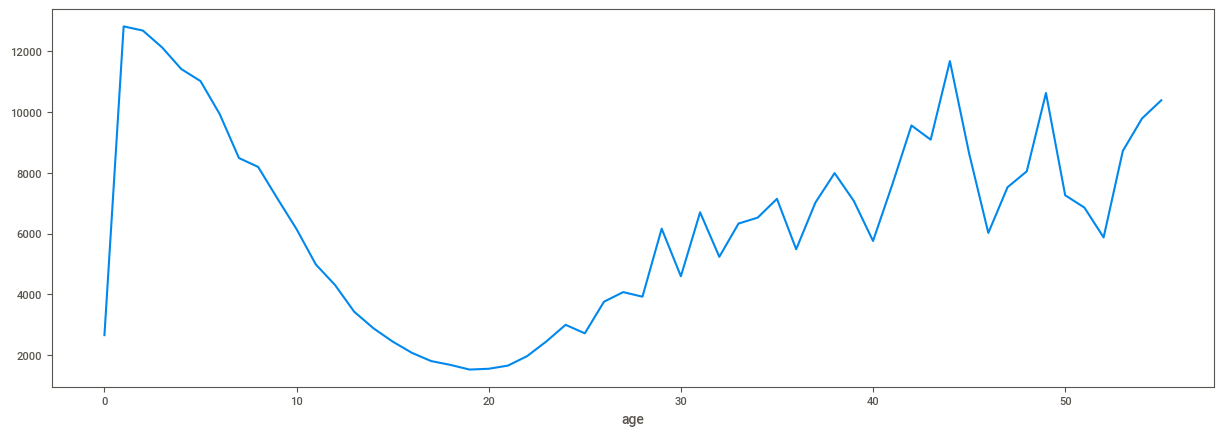

In [511]:
auto.groupby('age')['price'].agg('mean').plot(figsize=(15, 5));

**Вывод:**
Разделим показатель возраста на группы:
* Новые — до 5 лет включительно, т.к. разница между автомобилями в этот период невелика. Разброс средней стоимости составляет от 11013 евро до 12813 евро (не считая выброс 2659 евро для автомобилей до года - скорее всего автомобилей до года слишком мало в данных, что и привело к выбросу);
* Средние - автомобили 6-10 лет включительно. Не новые, но еще и не совсем старые. Разброс средней стоимости от 6144 евро до 9927 евро. На данные автомобили приходится резкий спад стоимости в зависимости от возраста - чем больше возраст, тем меньше средняя стоимость;
* Старые - от 11 до 28 лет включительно. Разброс стоимости от 1527 до 4985 евро. На данные автомобили приходится замедление падения стоимости, плато и постепенно восходящий тренд к концу периода;
* Ретро - от 29 до 39 лет включительно. Разброс стоимости от 4595 до 7988 евро. Стоимость таких автомобилей растет - чем больше возраст, тем дороже;
* Супер-ретро - от 40 до 55 лет включительно. Разброс стоимости от 5756 до 11671 евро. Колебания их средней стоимости скорее всего обусловлены малым количеством таких автомобилей.

In [512]:
#Добавляем тип возраста
auto['age_type'] = '0'
auto.loc[auto['age']<=5, 'age_type'] = 'new'
auto.loc[(auto['age']>5) & (auto['age']<=10), 'age_type'] = 'medium'
auto.loc[(auto['age']>10) & (auto['age']<=28), 'age_type'] = 'old'
auto.loc[(auto['age']>29) & (auto['age']<=39), 'age_type'] = 'retro'
auto.loc[auto['age']>39, 'age_type'] = 'super_retro'
#Проверка, не остались ли значения с 0
print(auto.loc[auto['age']=='0', 'age_type'].count())

0


#### Удаление ненужных признаков

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code', 'publication_days', 'age']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable number_of_pictures for analysis 1. Dropping this column
  warnings.warn(


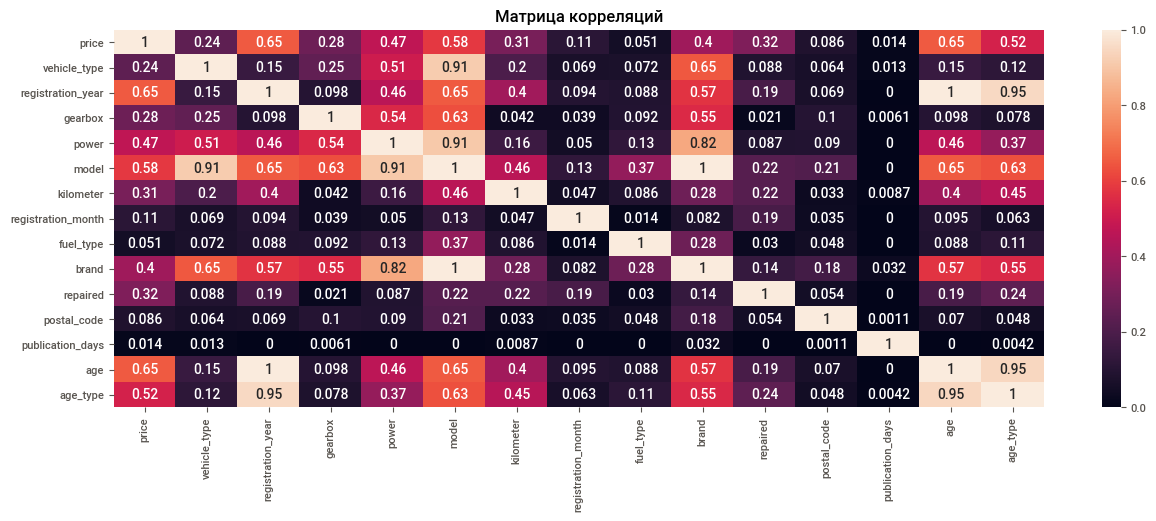

''

In [513]:
data = auto[auto.select_dtypes(exclude='datetime64[ns]').columns.to_list()]
fig, ax = plt.subplots()
sns.heatmap(data.phik_matrix(), annot=True)
ax.set_title('Матрица корреляций')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()
;

Ранее выяснили, что неинформативными являются следующие признаки:
* date_crawled, date_created, publication_days - так как выявлено, что в основном были выгружены анкеты, созданные не более 1 дня назад;
* registration_year и age - так как признаки заменены на более удобный в использовании показатель типа возраста автомобиля;
* registration_month - так как не было найдено объяснение возможной связи месяца регистрации и стоимости автомобиля;
* model - при построении предсказывающей модели наименования моделей нам не понадобятся, так как различные модели одного бренда различаются техническими характеристиками - мощностью, типом коробки передач, типом транспортного средства, и т.д. Получается, что признак модели уже закодирован в остальных признаках (см. матрицу корреляций), и поэтому признак Model нужно удалить;
* kilometer - так как в выгрузке в основном только автомобили с пробегом 125000 и 150000 км, что делает показатель не очень информативным (не хватает данных для автомобилей с другим пробегом);
* number_of_pictures - так как признак заполнен нулями;
* postal_code - по индексу можно определить местонахождение автомобиля, в зависимости от которого стоимость действительно может измениться. Но в моделях регрессии с увеличением почтового индекса будет увеличиваться/уменьшаться целевой показатель, в то время как увеличение стоимости автомобилей может происходить только для узких диапазонов индексов;
* last_seen  - так как не было найдено объяснение возможной связи даты последнего входа и стоимости автомобиля.

In [514]:
#Удаление ненужных столбцов
auto = auto.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'model', 'kilometer',
                  'number_of_pictures', 'postal_code', 'last_seen', 'publication_days', 'age'], axis=1)

#### Разделение данных на выборки

In [515]:
features = auto.drop('price', axis = 1)
target = auto['price']
quality_features = auto.select_dtypes(include='object').columns.to_list()
quantity_features = auto.select_dtypes(exclude='object').columns.to_list()
del (quantity_features[0]) #Удалим из перечня целевой признак
print('Качественные признаки', quality_features)
print('Количественные признаки', quantity_features)

features_train, features_test, target_train, target_test = train_test_split(features, target, 
    test_size = 0.2, random_state = 12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
    test_size = 0.25, random_state = 12345)

#Скопируем отдельно обучающие, валидационные и тестовые признаки, чтобы в дальнейшем провести для них OHE
features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

#Скопируем отдельно обучающие, валидационные и тестовые признаки, чтобы в дальнейшем провести для них OE
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

Качественные признаки ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'age_type']
Количественные признаки ['power']


In [516]:
for i in [features_train, features_valid, features_test, target_train, target_valid, target_test]:
    display(i.describe(include='all'))

vehicle_type gearbox          power fuel_type       brand repaired  \
count        131445  131445  131445.000000    131445      131445   131445   
unique            8       2            NaN         6          40        3   
top           sedan  manual            NaN    petrol  volkswagen       no   
freq          37191  105607            NaN    128920       26559    99907   
mean            NaN     NaN     116.003421       NaN         NaN      NaN   
std             NaN     NaN      46.008490       NaN         NaN      NaN   
min             NaN     NaN       0.002000       NaN         NaN      NaN   
25%             NaN     NaN      80.000000       NaN         NaN      NaN   
50%             NaN     NaN     110.000000       NaN         NaN      NaN   
75%             NaN     NaN     143.000000       NaN         NaN      NaN   
max             NaN     NaN     405.000000       NaN         NaN      NaN   

       age_type  
count    131445  
unique        6  
top         old  
freq      81873  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

vehicle_type gearbox         power fuel_type       brand repaired  \
count         43816   43816  43816.000000     43816       43816    43816   
unique            8       2           NaN         6          40        3   
top           sedan  manual           NaN    petrol  volkswagen       no   
freq          12608   35056           NaN     42965        8813    33428   
mean            NaN     NaN    116.604034       NaN         NaN      NaN   
std             NaN     NaN     45.944187       NaN         NaN      NaN   
min             NaN     NaN      0.003000       NaN         NaN      NaN   
25%             NaN     NaN     80.000000       NaN         NaN      NaN   
50%             NaN     NaN    110.000000       NaN         NaN      NaN   
75%             NaN     NaN    143.000000       NaN         NaN      NaN   
max             NaN     NaN    385.000000       NaN         NaN      NaN   

       age_type  
count     43816  
unique        6  
top         old  
freq      27218  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

vehicle_type gearbox         power fuel_type       brand repaired  \
count         43816   43816  43816.000000     43816       43816    43816   
unique            8       2           NaN         6          40        3   
top           sedan  manual           NaN    petrol  volkswagen       no   
freq          12382   35159           NaN     42926        8841    33358   
mean            NaN     NaN    115.818276       NaN         NaN      NaN   
std             NaN     NaN     46.186336       NaN         NaN      NaN   
min             NaN     NaN      0.001000       NaN         NaN      NaN   
25%             NaN     NaN     77.000000       NaN         NaN      NaN   
50%             NaN     NaN    110.000000       NaN         NaN      NaN   
75%             NaN     NaN    143.000000       NaN         NaN      NaN   
max             NaN     NaN    409.000000       NaN         NaN      NaN   

       age_type  
count     43816  
unique        6  
top         old  
freq      27433  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

count    131445.00000
mean       4861.82404
std        4331.32586
min         150.00000
25%        1500.00000
50%        3399.00000
75%        6990.00000
max       19990.00000
Name: price, dtype: float64

count    43816.000000
mean      4886.604642
std       4348.812432
min        200.000000
25%       1500.000000
50%       3400.000000
75%       6990.000000
max      19990.000000
Name: price, dtype: float64

count    43816.000000
mean      4833.312899
std       4334.396297
min        150.000000
25%       1500.000000
50%       3300.000000
75%       6900.000000
max      19999.000000
Name: price, dtype: float64

**Вывод:**

Данные между обучающей, валидационной и тестовой выборкой отличаются несущественно

#### OHE, OE и нормализация

In [517]:
#OHE
pd.options.mode.chained_assignment = None

encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder.fit(features_train_ohe[quality_features])
features_train_ohe[encoder.get_feature_names_out()] = (encoder.transform(features_train_ohe[quality_features]))
display(features_train_ohe.head())
features_train_ohe = features_train_ohe.drop(quality_features, axis=1)

#OHE для valid и test
features_valid_ohe[encoder.get_feature_names_out()] = (encoder.transform(features_valid_ohe[quality_features]))
display(features_valid_ohe.head())
features_valid_ohe = features_valid_ohe.drop(quality_features, axis=1)

features_test_ohe[encoder.get_feature_names_out()] = (encoder.transform(features_test_ohe[quality_features]))
display(features_test_ohe.head())
features_test_ohe = features_test_ohe.drop(quality_features, axis=1)

vehicle_type gearbox  power fuel_type       brand repaired age_type  \
120601        sedan  manual  136.0    petrol       honda      yes      old   
64592         small    auto   75.0    petrol        ford    other      old   
16343         sedan  manual  143.0    petrol         bmw       no   medium   
38405         small  manual   50.0    petrol  volkswagen       no      old   
158591        sedan  manual  118.0    petrol         bmw    other      old   

        vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  ...  \
120601                       0.0                 0.0                 0.0  ...   
64592                        0.0                 0.0                 0.0  ...   
16343                        0.0                 0.0                 0.0  ...   
38405                        0.0                 0.0                 0.0  ...   
158591                       0.0                 0.0                 0.0  ...   

        brand_trabant  brand_volkswagen  brand_volvo  repaired_other  \
120601            0.0               0.0          0.0             0.0   
64592             0.0               0.0          0.0             1.0   
16343             0.0               0.0          0.0             0.0   
38405             0.0               1.0          0.0             0.0   
158591            0.0               0.0          0.0             1.0   

        repaired_yes  age_type_medium  age_type_new  age_type_old  \
120601           1.0              0.0           0.0           1.0   
64592            0.0              0.0           0.0           1.0   
16343            0.0              1.0           0.0           0.0   
38405            0.0              0.0           0.0           1.0   
158591           0.0              0.0           0.0           1.0   

        age_type_retro  age_type_super_retro  
120601             0.0                   0.0  
64592              0.0                   0.0  
16343              0.0                   0.0  
38405              0.0                   0.0  
158591             0.0                   0.0  

[5 rows x 66 columns]

vehicle_type gearbox  power fuel_type brand repaired age_type  \
114053        sedan  manual  163.0    petrol   bmw       no      old   
152906        sedan  manual  150.0    petrol  audi       no      old   
202254        wagon  manual  163.0    petrol   bmw       no   medium   
75283         wagon  manual  109.0    petrol   kia      yes   medium   
15269         sedan    auto   71.0    petrol  opel       no      old   

        vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  ...  \
114053                       0.0                 0.0                 0.0  ...   
152906                       0.0                 0.0                 0.0  ...   
202254                       0.0                 0.0                 0.0  ...   
75283                        0.0                 0.0                 0.0  ...   
15269                        0.0                 0.0                 0.0  ...   

        brand_trabant  brand_volkswagen  brand_volvo  repaired_other  \
114053            0.0               0.0          0.0             0.0   
152906            0.0               0.0          0.0             0.0   
202254            0.0               0.0          0.0             0.0   
75283             0.0               0.0          0.0             0.0   
15269             0.0               0.0          0.0             0.0   

        repaired_yes  age_type_medium  age_type_new  age_type_old  \
114053           0.0              0.0           0.0           1.0   
152906           0.0              0.0           0.0           1.0   
202254           0.0              1.0           0.0           0.0   
75283            1.0              1.0           0.0           0.0   
15269            0.0              0.0           0.0           1.0   

        age_type_retro  age_type_super_retro  
114053             0.0                   0.0  
152906             0.0                   0.0  
202254             0.0                   0.0  
75283              0.0                   0.0  
15269              0.0                   0.0  

[5 rows x 66 columns]

vehicle_type gearbox  power fuel_type       brand repaired age_type  \
152063        sedan  manual   90.0    petrol        audi       no   medium   
94091         small  manual   50.0    petrol  volkswagen       no      old   
102950        sedan    auto  122.0    petrol  volkswagen       no      new   
163668  convertible  manual  160.0    petrol        audi       no   medium   
121018        sedan  manual  116.0    petrol         bmw      yes      old   

        vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  ...  \
152063                       0.0                 0.0                 0.0  ...   
94091                        0.0                 0.0                 0.0  ...   
102950                       0.0                 0.0                 0.0  ...   
163668                       1.0                 0.0                 0.0  ...   
121018                       0.0                 0.0                 0.0  ...   

        brand_trabant  brand_volkswagen  brand_volvo  repaired_other  \
152063            0.0               0.0          0.0             0.0   
94091             0.0               1.0          0.0             0.0   
102950            0.0               1.0          0.0             0.0   
163668            0.0               0.0          0.0             0.0   
121018            0.0               0.0          0.0             0.0   

        repaired_yes  age_type_medium  age_type_new  age_type_old  \
152063           0.0              1.0           0.0           0.0   
94091            0.0              0.0           0.0           1.0   
102950           0.0              0.0           1.0           0.0   
163668           0.0              1.0           0.0           0.0   
121018           1.0              0.0           0.0           1.0   

        age_type_retro  age_type_super_retro  
152063             0.0                   0.0  
94091              0.0                   0.0  
102950             0.0                   0.0  
163668             0.0                   0.0  
121018             0.0                   0.0  

[5 rows x 66 columns]

In [518]:
#OE
pd.options.mode.chained_assignment = None

encoder = OrdinalEncoder(handle_unknown='error')
encoder.fit(features_train_oe[quality_features])
features_train_oe[encoder.get_feature_names_out()] = (encoder.transform(features_train_oe[quality_features]))
display(features_train_oe.head())
features_train_oe = features_train_oe.drop(quality_features, axis=1)

#OE для valid и test
features_valid_oe[encoder.get_feature_names_out()] = (encoder.transform(features_valid_oe[quality_features]))
display(features_valid_oe.head())
features_valid_oe = features_valid_oe.drop(quality_features, axis=1)

features_test_oe[encoder.get_feature_names_out()] = (encoder.transform(features_test_oe[quality_features]))
display(features_test_oe.head())
features_test_oe = features_test_oe.drop(quality_features, axis=1)

vehicle_type  gearbox  power  fuel_type  brand  repaired  age_type
120601           4.0      1.0  136.0        5.0   11.0       2.0       3.0
64592            5.0      0.0   75.0        5.0   10.0       1.0       3.0
16343            4.0      1.0  143.0        5.0    2.0       0.0       1.0
38405            5.0      1.0   50.0        5.0   38.0       0.0       3.0
158591           4.0      1.0  118.0        5.0    2.0       1.0       3.0

vehicle_type  gearbox  power  fuel_type  brand  repaired  age_type
114053           4.0      1.0  163.0        5.0    2.0       0.0       3.0
152906           4.0      1.0  150.0        5.0    1.0       0.0       3.0
202254           7.0      1.0  163.0        5.0    2.0       0.0       1.0
75283            7.0      1.0  109.0        5.0   15.0       2.0       1.0
15269            4.0      0.0   71.0        5.0   24.0       0.0       3.0

vehicle_type  gearbox  power  fuel_type  brand  repaired  age_type
152063           4.0      1.0   90.0        5.0    1.0       0.0       1.0
94091            5.0      1.0   50.0        5.0   38.0       0.0       3.0
102950           4.0      0.0  122.0        5.0   38.0       0.0       2.0
163668           1.0      1.0  160.0        5.0    1.0       0.0       1.0
121018           4.0      1.0  116.0        5.0    2.0       2.0       3.0

In [519]:
#Нормализация
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
features_train[quantity_features] = scaler.fit_transform(features_train[quantity_features])
features_train.head()

vehicle_type gearbox     power fuel_type       brand repaired age_type
120601        sedan  manual  0.434630    petrol       honda      yes      old
64592         small    auto -0.891218    petrol        ford    other      old
16343         sedan  manual  0.586776    petrol         bmw       no   medium
38405         small  manual -1.434598    petrol  volkswagen       no      old
158591        sedan  manual  0.043396    petrol         bmw    other      old

In [520]:
#Нормализация для features_valid, features_test
features_valid[quantity_features] = scaler.transform(features_valid[quantity_features])
display(features_valid.head())

features_test[quantity_features] = scaler.transform(features_test[quantity_features])
display(features_test.head())

#Нормализация для копий признаков
features_train_ohe[quantity_features] = scaler.transform(features_train_ohe[quantity_features])
features_valid_ohe[quantity_features] = scaler.transform(features_valid_ohe[quantity_features])
features_test_ohe[quantity_features]  = scaler.transform(features_test_ohe[quantity_features])

features_train_oe[quantity_features] = scaler.transform(features_train_oe[quantity_features])
features_valid_oe[quantity_features] = scaler.transform(features_valid_oe[quantity_features])
features_test_oe[quantity_features]  = scaler.transform(features_test_oe[quantity_features])

vehicle_type gearbox     power fuel_type brand repaired age_type
114053        sedan  manual  1.021480    petrol   bmw       no      old
152906        sedan  manual  0.738923    petrol  audi       no      old
202254        wagon  manual  1.021480    petrol   bmw       no   medium
75283         wagon  manual -0.152221    petrol   kia      yes   medium
15269         sedan    auto -0.978158    petrol  opel       no      old

vehicle_type gearbox     power fuel_type       brand repaired age_type
152063        sedan  manual -0.565190    petrol        audi       no   medium
94091         small  manual -1.434598    petrol  volkswagen       no      old
102950        sedan    auto  0.130337    petrol  volkswagen       no      new
163668  convertible  manual  0.956275    petrol        audi       no   medium
121018        sedan  manual -0.000074    petrol         bmw      yes      old

## Обучение моделей

### Подготовка к кросс-валидации

In [521]:
#Функция RMSE
def rmse(target, pred):
    return (mean_squared_error(target, pred))**0.5

my_scorer = make_scorer(rmse, greater_is_better=False)

### Модель линейной регрессии 

In [522]:
%%time
print('Модель линейной регрессии:')
lin_model = LinearRegression()
lin_model.fit(features_train_ohe, target_train)
print('Время обучения:')

Модель линейной регрессии:
Время обучения:
CPU times: user 1.17 s, sys: 1.09 s, total: 2.26 s
Wall time: 2.24 s


In [523]:
%%time
pred_valid = lin_model.predict(features_valid_ohe)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 25.6 ms, sys: 70.1 ms, total: 95.7 ms
Wall time: 99.7 ms


In [524]:
%%time
lin_rmse = np.mean(cross_val_score(lin_model, features_train_ohe, target_train, scoring=my_scorer, cv=5))
print('RMSE модели:', lin_rmse*(-1))

RMSE модели: 2527.2376770427627
CPU times: user 4.24 s, sys: 4.66 s, total: 8.9 s
Wall time: 8.89 s


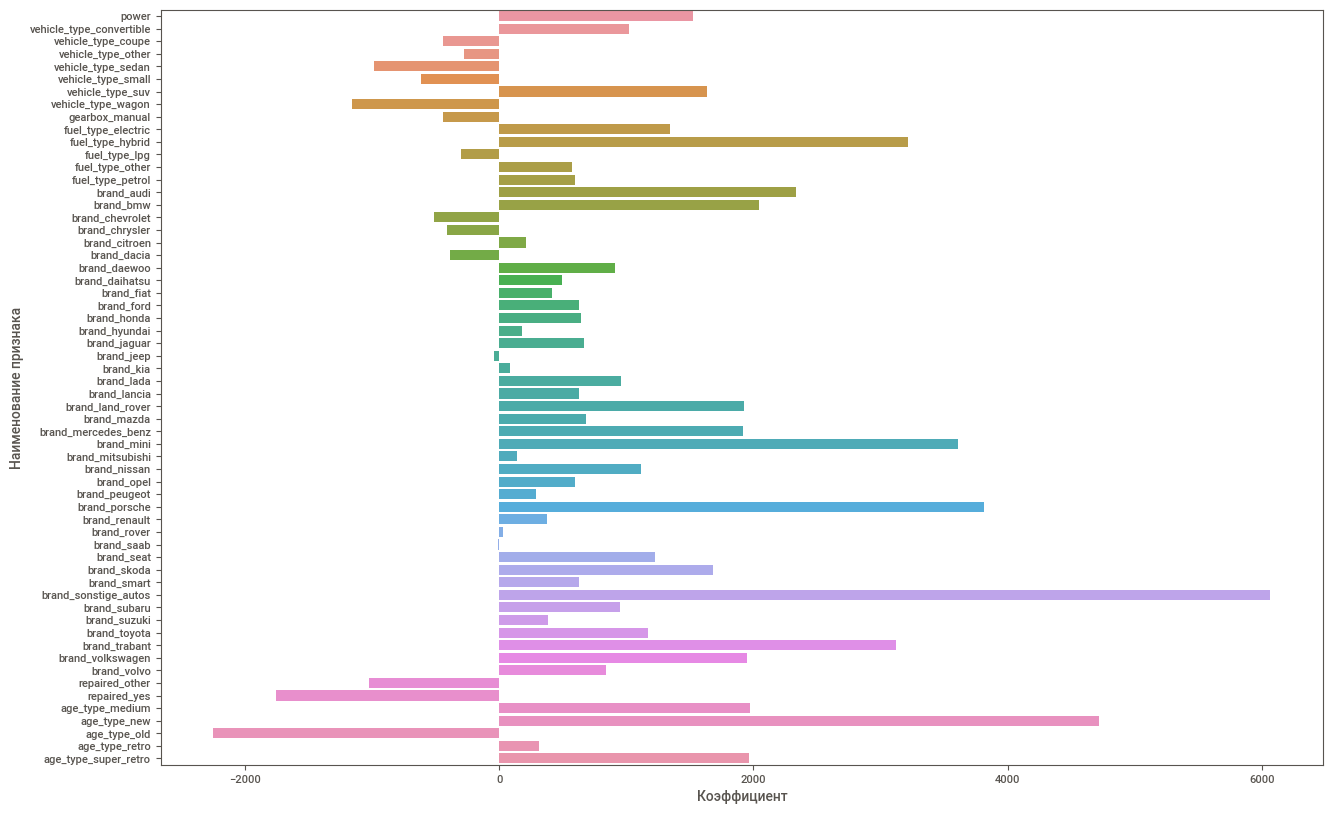

In [525]:
#График важности факторов
coef_values = pd.DataFrame(data=lin_model.coef_, columns=['coef'])
columns = pd.DataFrame(data=features_train_ohe.columns, columns=['columns'])
coef_table = columns.join(coef_values)
coef_table.plot

fig, ax = plt.subplots(figsize=(15, 10))    
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient = 'h')
ax.set_ylabel('Наименование признака')
diagram.set_xlabel('Коэффициент');

### Модель случайного леса после OE

In [526]:
%%time
print('Модель случайного леса:')
    
forest_model = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=12345)
forest_model.fit(features_train_oe, target_train)
print('Время обучения:')

Модель случайного леса:
Время обучения:
CPU times: user 4.48 s, sys: 31.1 ms, total: 4.51 s
Wall time: 4.52 s


In [527]:
%%time
pred_valid = forest_model.predict(features_valid_oe)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 398 ms, sys: 4.2 ms, total: 402 ms
Wall time: 411 ms


In [528]:
%%time
forest_rmse = np.mean(cross_val_score(forest_model, features_train_oe, target_train, scoring=my_scorer, cv=5))
print('RMSE модели:', forest_rmse*(-1))

RMSE модели: 3479.4104348434585
CPU times: user 19.1 s, sys: 81.4 ms, total: 19.2 s
Wall time: 20 s


In [529]:
print(forest_model.feature_importances_)

[1.]


### Модель случайного леса после OHE

In [530]:
%%time
print('Модель случайного леса:')
    
forest_model_ohe = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=12345)
forest_model_ohe.fit(features_train_ohe, target_train)
print('Время обучения:')

Модель случайного леса:
Время обучения:
CPU times: user 53.6 s, sys: 196 ms, total: 53.8 s
Wall time: 53.9 s


In [531]:
%%time
pred_valid_ohe = forest_model_ohe.predict(features_valid_ohe)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 725 ms, sys: 473 µs, total: 725 ms
Wall time: 735 ms


In [532]:
%%time
forest_rmse_ohe = np.mean(cross_val_score(forest_model_ohe, features_train_ohe, target_train, scoring=my_scorer, cv=5))
print('RMSE модели:', forest_rmse_ohe*(-1))

RMSE модели: 2196.9403201499604
CPU times: user 3min 21s, sys: 768 ms, total: 3min 22s
Wall time: 3min 23s


### Модель LightGBM после OE

In [534]:
%%time
print('Модель LightGBM:')

lightgbm_model = LGBMRegressor(max_depth=10, n_estimators=150, random_state=12345)
lightgbm_model.fit(features_train_oe, target_train, eval_metric='rmse')
print('Время обучения:')

Модель LightGBM:
Время обучения:
CPU times: user 6min 50s, sys: 7.55 s, total: 6min 57s
Wall time: 7min 7s


In [535]:
%%time
pred_valid = lightgbm_model.predict(features_valid_oe)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 454 ms, sys: 9.15 ms, total: 463 ms
Wall time: 409 ms


In [536]:
%%time
lightgbm_rmse = rmse(target_valid, pred_valid)
print('RMSE модели LightGBM:', lightgbm_rmse)

RMSE модели LightGBM: 3489.351673875696
CPU times: user 2.1 ms, sys: 64 µs, total: 2.16 ms
Wall time: 1.3 ms


In [537]:
print(lightgbm_model.feature_importances_)

[4099]


### Модель LightGBM после OHE

In [538]:
%%time
print('Модель LightGBM:')

lightgbm_model_ohe = LGBMRegressor(max_depth=10, n_estimators=150, random_state=12345)
lightgbm_model_ohe.fit(features_train_ohe, target_train, eval_metric='rmse')
print('Время обучения:')

Модель LightGBM:
Время обучения:
CPU times: user 8min 21s, sys: 9.01 s, total: 8min 30s
Wall time: 8min 37s


In [539]:
%%time
pred_valid_ohe = lightgbm_model_ohe.predict(features_valid_ohe)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 469 ms, sys: 1.73 ms, total: 471 ms
Wall time: 515 ms


In [540]:
%%time
lightgbm_rmse_ohe = rmse(target_valid, pred_valid_ohe)
print('RMSE модели LightGBM:', lightgbm_rmse_ohe)

RMSE модели LightGBM: 2112.9669427165
CPU times: user 0 ns, sys: 4.35 ms, total: 4.35 ms
Wall time: 56.9 ms


### Модель CatBoost

In [541]:
%%time
print('Модель CatBoost:')

cat_features = features_train.select_dtypes(include='object').columns.to_list()
catboost_model = CatBoostRegressor(iterations=100, loss_function='RMSE', random_state=12345)
catboost_model.fit(features_train, target_train, cat_features=cat_features, verbose=25)
print('Время обучения:')

Модель CatBoost:
Learning rate set to 0.5
0:	learn: 3199.1177189	total: 59.2ms	remaining: 5.86s
25:	learn: 2199.8415477	total: 1.17s	remaining: 3.34s
50:	learn: 2138.2902768	total: 2.28s	remaining: 2.19s
75:	learn: 2103.1405990	total: 3.38s	remaining: 1.07s
99:	learn: 2085.8747296	total: 4.46s	remaining: 0us
Время обучения:
CPU times: user 4.65 s, sys: 62 ms, total: 4.71 s
Wall time: 5.15 s


In [542]:
%%time
pred_valid = catboost_model.predict(features_valid)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 55.7 ms, sys: 7.72 ms, total: 63.4 ms
Wall time: 60.4 ms


In [543]:
%%time
catboost_rmse = rmse(target_valid, pred_valid)
print('RMSE модели CatBoost:', catboost_rmse)

RMSE модели CatBoost: 2117.5568624736366
CPU times: user 0 ns, sys: 3.22 ms, total: 3.22 ms
Wall time: 1.85 ms


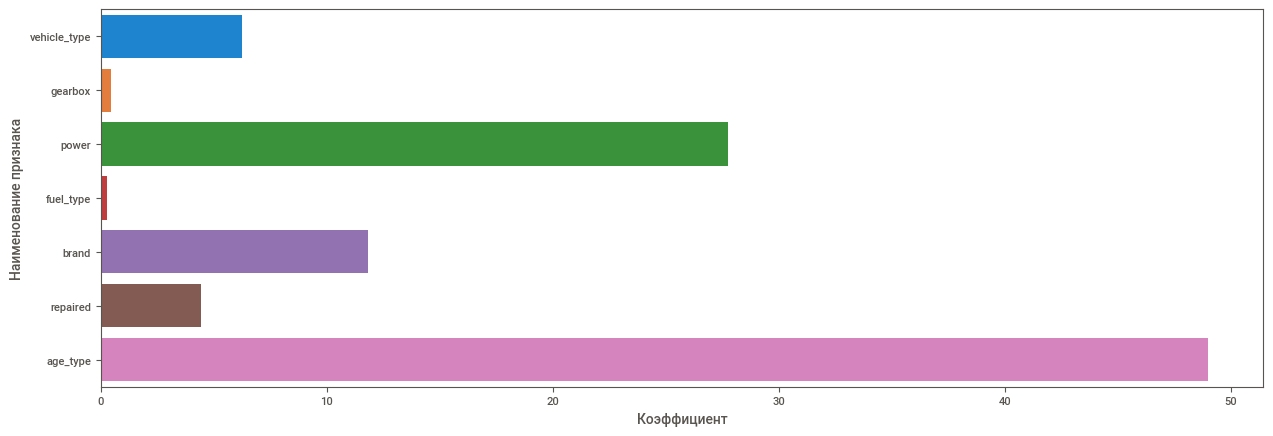

In [544]:
#График важности факторов
coef_values = pd.DataFrame(data=catboost_model.get_feature_importance(), columns=['coef'])
columns = pd.DataFrame(data=features_train.columns, columns=['columns'])
coef_table = columns.join(coef_values)
coef_table.plot

fig, ax = plt.subplots(figsize=(15, 5))    
diagram = sns.barplot(data=coef_table, y='columns', x='coef', orient = 'h')
ax.set_ylabel('Наименование признака')
diagram.set_xlabel('Коэффициент');

**Вывод:**

Результаты обучения моделей:

Линейная модель:
Время обучения: 2.64 s
Скорость предсказания: 92.5 ms
RMSE: 2527.2

Модель случайного леса после OE:
Время обучения: 4.81 s
Скорость предсказания:  387 ms
RMSE: 3479.4

Модель случайного леса после OHE:
Время обучения: 57.2 s
Скорость предсказания:  761 ms
RMSE: 2196.9

Модель LightGBM после OE:
Время обучения: 7min 16s
Скорость предсказания: 431 ms
RMSE: 3489.3

Модель LightGBM после OHE:
Время обучения: 10min 44s
Скорость предсказания: 367 ms
RMSE: 2112.9

Модель CatBoost:
Время обучения: 5.81 s
Скорость предсказания: 82.5 ms
RMSE: 2117.55

## Анализ моделей

**Вывод:**
    
* Самой быстрой по времени обучения является линейная модель, вторая - CatBoost
* Самой быстрой по времени предсказания - модель CatBoost, вторая - линейная модель
* С наименьшим значением RMSE - модель LightGBM после OHE, вторая - модель CatBoost. 

Приемлемое значение RMSE наблюдается только у моделей случайного леса после OHE, LightGBM и CatBoost. Но модель случайного леса после OHE и LightGBM обучаются слишком долго. Таким образом, в качестве наиболее подходящей под критерии заказчика выберем модель CatBoost

In [545]:
%%time
#Проверим время предсказания и качество модели на тестовой выборке:
pred_test = catboost_model.predict(features_test)
print('Скорость предсказания:')

Скорость предсказания:
CPU times: user 63.2 ms, sys: 154 µs, total: 63.4 ms
Wall time: 69.3 ms


In [546]:
catboost_rmse = rmse(target_test, pred_test)
print('RMSE модели CatBoost:', catboost_rmse)

RMSE модели CatBoost: 2113.405333493966


**Вывод:**
    
Качество модели изменилось несущественно. RMSE модели CatBoost: 2113

## Вывод

**1. Описание данных**
* Загружен свод данных с количеством строк, равным 354369. В своде содержатся данные по анкетам, выгруженным в 2016 году. В данных приведена информация о 40 брендах автомобилей, 250 различных моделей, 8 типов автомобилей, 2 типов коробки передач, работающих на 6 различных типах топлива;
* В выгрузке больше всего автомобилей Volkswagen, Opel, BMW, Mercedes-Benz, Audi, Ford, Renault. Автомобили с самой низкой стоимостью: Daewoo, Rover, Trabant. При этом заводы Rover и Trabant уже проданы/закрыты, поэтому в продаже есть только старые модели. Автомобили с самой высокой стоимостью: Porsche, Mini, Land Rover, Jeep, Jaguar;
* Чаще всего встречаются автомобили типов sedan, small и wagon. При этом эти типы автомобилей не обладают высокой средней стоимостью - обычно до 5 000 евро;
* Автомобилей с ручной коробкой передач в выгрузке более чем в 4 раза больше, чем автомобилей на автоматической коробке. При этом автомобили с автоматической коробкой более чем в 1,5 раза дороже, чем автомобили на ручной;
* В основном в выгрузке представлены автомобили, работающие на бензине. Автомобилей, использующих другой тип топлива, совсем немного, поэтому модель может плохо предсказывать их стоимость;
* Автомобилей, которые не ремонтировались, в выборке примерно в 5 раз больше, чем тех, которые побывали в ремонте. В среднем стоимость отремонтированного автомобиля в 2,5 раза меньше, чем неотремонтированного;
* Разброс стоимости автомобилей составляет в среднем от 1050 до 6400 евро;
* Мощность автомобилей в среднем находится в диапазоне от 69 до 143;
* Год регистрации автомобилей в основном находится в диапазоне от 1999 по 2008;
* Возраст автомобиля в среднем находится в диапазоне от 8 до 17 лет;
* На этапе обработки данных проведено заполнение пропусков, удаление и корректировка ошибок в данных, устранение аномалий (удалено 21.3%% от данных после предыдущмх этапов обработки), устранение дубликатов, удаление ненужных для моделей признаков, OHE, OE и нормализация данных.

**2. Результат обучения моделей**
* Линейная модель: Время обучения: 2.64 s Скорость предсказания: 92.5 ms RMSE: 2527.2
* Модель случайного леса после OE: Время обучения: 4.81 s Скорость предсказания: 387 ms RMSE: 3479.4
* Модель случайного леса после OHE: Время обучения: 57.2 s Скорость предсказания: 761 ms RMSE: 2196.9
* Модель LightGBM после OE: Время обучения: 7min 16s Скорость предсказания: 431 ms RMSE: 3489.3
* Модель LightGBM после OHE: Время обучения: 10min 44s Скорость предсказания: 367 ms RMSE: 2112.9
* Модель CatBoost: Время обучения: 5.81 s Скорость предсказания: 82.5 ms RMSE: 2117.55

**3. Анализ моделей**

Наиболее подходящей под критерии быстроты обучения, предсказания и качества модели является модель CatBoost.
После тестирования время предсказаня составило 57.8 ms, а RMSE = 2113.4